# Inference in Probabilistic Models - Sampling Methods

Michael Habeck - University Hospital Jena - michael.habeck@uni-jena.de

# Lecture 4: Markov chain Monte Carlo

## Outline

* Markov chains

# Where do we stand?

* Monte Carlo approximation: use stochastic simulations to estimate deterministic quantities. Only stochastic and asymptotic guarantees. 

* We can design special purpose solutions using variable transformation methods, but these are not broadly applicable. Examples: inversion of cdf, Cartesian to polar coordinates (Box-Muller), affine transformation for general multivariate Gaussians

* We tried to overcome special purpose approaches by using a *helper* or *proposal* distribution (rejection and importance sampling)

* Although these approaches are more versatile, we encountered several challenges: Finding a good proposal distribution in the first place. Depending on the method, guarantee that all requirements are met. For example, rejection sampling needs an upper bound on the ratio of target and proposal distribution.

* Major challenges in high dimensions for both rejection and importance sampling

# Markov chains

Up to this point, we have only considered sampling approaches based on identically and independently distributed samples: all $x^{(s)}$ are generated from the same distribution independent of each other, either by drawing from 

$$
x^{(s)}\sim p(x)
$$ 

where $p(x)$ is the target distribution, or by drawing from 

$$
x^{(s)}\sim q(x)
$$

where $q(x)$ is a proposal or helper distribution. 

The idea of [__Markov chain Monte Carlo (MCMC)__](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods is to give up the *independence* of successive samples and generate sequences of states where $x^{(s)}$ depends on the previous sample $x^{(s-1)}$. Our hope is that also when introducing these correlations, the Monte Carlo approximation

\begin{equation}\label{eq:MCapproximation}
\frac{1}{S} \sum_{s=1}^S f\bigl(x^{(s)}\bigr) \approx \mathbb E_p[f]
\end{equation}

is still valid. This is justified by our intuition that as long as we run the simulation long enough correlations between two states $x^{(s')}$ and $x^{(s)}$ will vanish with large $|s'-s|$, and the samples $x^{(s)}$ will approximately follow $p(x)$ for large $s$

In the following, we will restrict ourselves to *discrete* sample spaces $\mathcal X$ (finite or countably infinite). Markov chains defined on continuous sample spaces can be treated in a similar, yet mathematically much more involved fashion (measure theory, etc.). 

## Definition of Markov chains

Markov chains are models for dynamical systems with possibly uncertain transitions between various system states. In our context, the state space of the stochastic dynamics is the sample space $\mathcal X$. 

A (first order) [*Markov chain*](https://en.wikipedia.org/wiki/Markov_chain) is a *memoryless* stochastic process $\left(x^{(s)}\right)_{s\ge 0}$ that has the following [property](https://en.wikipedia.org/wiki/Markov_property)

\begin{equation}\label{eq:MarkovChain}
\Pr\bigl(x^{(s+1)} \mid x^{(s)}, \ldots, x^{(1)}\bigr) = \Pr\bigl(x^{(s+1)} \mid x^{(s)}\bigr)
\end{equation}

with $x^{(s)} \in \mathcal X$. That is, the probability of finding the system in state $x^{(s+1)}$ only depends on the *last* state $x^{(s)}$, not on the previous states before the last state. In this sense, Markov chains have no memory. A Markov chain is uniquely characterized by 

1. the *distribution of the initial state* $x^{(0)} \sim p^{(0)}$ and 

2. the *transition probabilities* $\Pr(y\mid x)$ for all $x, y \in \mathcal X$. 

Note that we are dealing with *time-homogeneous* Markov chains whose transition probabilities do not depend on $s$. 

*Remark:* I am here sticking to our convention of using the superscript $(\cdot)^{(s)}$ to denote samples, because we will later use Markov chains to generate samples from a probabilistic model. However, at this point we should think of $s$ as a discrete time. 

## Graph representation

Due to its simple structure, Markov chains can be represented as directed graphs where the nodes of the graph represent the different states in $\mathcal X$ and the edges transition probabilities between nodes $y$ and $x$ that are greater than zero, i.e. if $\Pr(x\mid y) > 0$, then we introduce an arrow between $y$ and $x$. These graphs are called *transition graphs*. 

For example the two-state Markov chain with transition probabilities $\Pr(x_2\mid x_1) = \alpha$ and $\Pr(x_1\mid x_2)=\beta$ can be represented by the transition graph:

![Two-state model](images/twostate.png "Two-state Markov model")

## Transition matrix

Since the transition probability depends only on the last state, we can summarize all probabilities in a *transition matrix*

\begin{equation}\label{eq:transition-matrix}
    P(x, y) = \Pr(x \mid y)
\end{equation}

For continuous sample spaces, the transition matrix becomes a transition operator or [Markov kernel](https://en.wikipedia.org/wiki/Markov_kernel). For the above two-state system we have

\begin{equation}\label{eq:twostate}
P(x, y) = \begin{pmatrix}
1 - \alpha & \beta \\
\alpha & 1 - \beta \\
\end{pmatrix}
\end{equation}

where $\alpha, \beta \in [0, 1]$.

In discrete sample spaces, $P(x, y)$ is the probability that we jump from state $y\in\mathcal X$ to state $x\in\mathcal X$. Because we are dealing with conditional probabilities, we have

\begin{equation}\label{eq:transition-matrix2}
\sum_{x\in\mathcal X} P(x, y) = 1, \,\,\, P(x, y) \ge 0\, .
\end{equation}

The first condition can be written in matrix-vector notation

\begin{equation}\label{eq:leftstochastic}
\mathbb 1^T\!P = \mathbb 1^T
\end{equation}

where 

\begin{equation}\label{eq:one}
\mathbb 1 = \begin{pmatrix}
1 \\
\vdots\\
1\\
\end{pmatrix}
\end{equation}

is a column vector whose elements are all one, and $P$ is the transition matrix. Non-negative square matrices that satisfy condition (\ref{eq:leftstochastic}) are called [*(left) stochastic*](https://en.wikipedia.org/wiki/Stochastic_matrix) matrices. The qualifier "left" stems from the fact that the *columns* of $P(x, y)$ are probability vectors, so multiplication with $\mathbb 1^T$ from the left produces one for each column. 

### Left versus right stochastic matrices

* Beware that there are different conventions for how to define transition matrices. Mathematicians tend to use the convention $P(x, y) = \Pr(y\mid x)$, whereas Physicists tend to use $P(x, y) = \Pr(x\mid y)$. In the first case, the row sums are one, whereas in the second case the column sums are one. 

* Note that, as a consequence of the previous comment, in the mathematics literature, and probably also the computer science literature, transition matrices of first-order Markov processes are *right stochastic*. Here, we follow the physics convention of using *left stochastic* transition matrices to represent the transition probabilities of Markov processes. One reason is that in the left stochastic convention the position of the arguments in $P(x, y)$ directly reflects the dependence in the conditional probability $\Pr(x\mid y)$. Another reason is that we will later see that some of the *right* eigenvectors of $P$ (in the left stochastic convention) play a crucial role (stationary distributions). Linear algebra packages typically compute right eigenvectors (so we don't have to remember to transpose the matrix when we compute eigenvectors...)

## Eigenvalues of transition matrices

A direct consequence of the stochasticity of the transition matrix of a Markov chain is that the absolute value ([modulus](https://en.wikipedia.org/wiki/Absolute_value)) of the (complex) eigenvalues $\lambda$ of $P$ are smaller than or equal to one. 

This is straightforward to see: Let $u$ be a left eigenvector of $P$ with $u^T\!P = \lambda u^T$. Therefore, 

$$
\lambda u(x) = \sum_{y\in \mathcal X} P(y, x) u(y)\,\,\, \Rightarrow\,\,\, |\lambda|  = \left|\sum_{y\in \mathcal X} P(y, x) \frac{u(y)}{|u(x)|}\right|
$$

for all $x$ with $|u(x)|>0$. If we pick the element $x$ with the largest absolute value, then all ratios $|u(y)/u(x)|$ are smaller than or equal to one. Therefore, by applying the triangle inequality we get

$$
|\lambda| \le \sum_{y\in \mathcal X} |P(y, x)|\, |u(y)|/|u(x)| \le \sum_{y\in\mathcal X} P(y, x) = 1\, .
$$

We see that $\mathbb 1$ is a left eigenvector that attains the maximum (absolute) eigenvalue.

Since left and right eigenvectors have the same eigenvalues, the above upper limit is also valid for right eigenvalues (the [characteristic polynomials](https://en.wikipedia.org/wiki/Characteristic_polynomial) of $P$ and $P^T$ are the identical). 

## Simulation of Markov chains

The algorithm for simulating a Markov chain is very simple:

1. $x^{(0)} \sim p^{(0)}(x)$

2. $x^{(s+1)} \sim P\bigl(x, x^{(s)}\bigr)$ 

In the first step, $p^{(0)}$ is the initial distribution of states, for example a uniform distribution. In the second step, we simply pick the column vector corresponding to state $x^{(s)}$ and draw a random sample from it. This generates a random walk on the graph representing a Markov chain. We have previously discussed how to sample states according to a pmf by using uniformly distributed pseudo-random numbers:

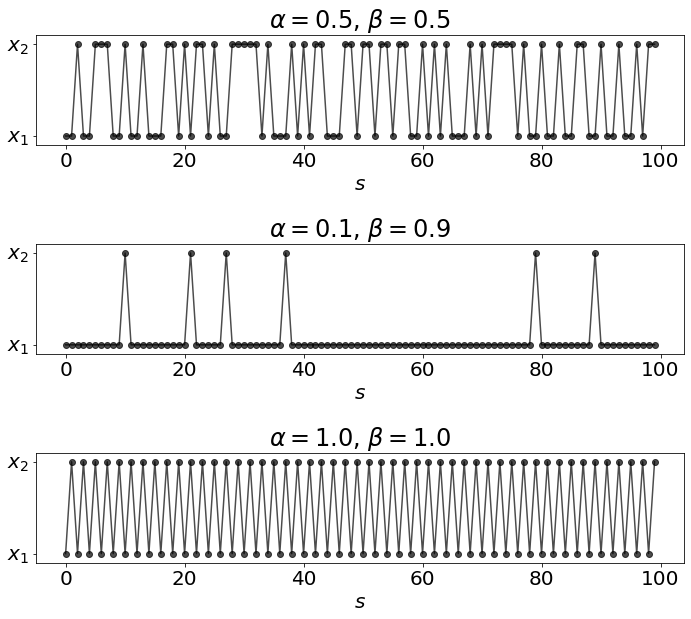

In [1]:
import numpy as np
import matplotlib.pylab as plt

plt.rc('font', size=20)

def transition_matrix(alpha, beta):
    return np.array([[1-alpha, beta], 
                     [alpha, 1-beta]])
    
def sample_chain(S, alpha=0.5, beta=0.5, x0=0):
    X = [x0]
    P = transition_matrix(alpha, beta)
    while len(X) < S:
        p = P[:,X[-1]]
        X.append(np.random.multinomial(1, p).argmax())
    return np.array(X)

S = 100
kw = dict(yticks=[0, 1], ylim=[-0.1, 1.1], yticklabels=['$x_1$', '$x_2$'], xlabel='$s$')
fig, ax = plt.subplots(3, 1, figsize=(10, 9), subplot_kw=kw)
ax = list(ax.flat)
for i, (alpha, beta) in enumerate([(0.5, 0.5), (0.1, 0.9), (1., 1.)]):
    X = sample_chain(S, alpha, beta)
    ax[i].set_title(r'$\alpha={0:.1f}$, $\beta={1:.1f}$'.format(alpha, beta))
    ax[i].plot(X, color='k', alpha=0.7, marker='o');
fig.tight_layout()

## Distribution propagation

If the initial state $x^{(0)}$ follows $p^{(0)}$, the marginal distribution of the next state $x^{(1)}$ is

$$
p^{(1)}(x) = \sum_{y\in\mathcal X} P(x, y)\, p^{(0)}(y)\, .
$$

The marginal distribution of the $(s+1)$-th state in a Markov chain follows the distribution

\begin{equation}\label{eq:marginalMC}
p^{(s+1)}(x) = \sum_{y\in\mathcal X} P(x, y)\, p^{(s)}(y)\, . 
\end{equation}

Repeating the same argument for $p^{(s)}$, we have

\begin{equation}\label{eq:marginalMC2}
p^{(s+1)}(x) = \sum_{y, z\in\mathcal X} P(x, y)\, P(y, z) \, p^{(s-1)}(z) = 
\sum_{z\in\mathcal X} \left(\sum_{y\in\mathcal X} P(x, y)\, P(y, z) \right) \, p^{(s-1)}(z)\, . 
\end{equation}

The expression in brackets, $\sum_{y\in\mathcal X} P(x, y)\, P(y, z)$, is the transition matrix for making two successive transitions. By generalizing the argument, we obtain the [Chapman-Kolmogorov equation](https://en.wikipedia.org/wiki/Chapman%E2%80%93Kolmogorov_equation).

In matrix-vector notation, we have

$$
p^{(s+1)} = Pp^{(s)}
$$

where $p^{(s)}$ are now vectors in the [probability simplex](https://en.wikipedia.org/wiki/Simplex#Probability) and $P$ is the transition matrix (always assuming the *left stochastic* convention in the context of this notebook!). 

By applying the argument successively, we obtain a representation of the marginal distribution of the $s$-th state in terms of [matrix powers](https://mathworld.wolfram.com/MatrixPower.html) of the transition matrix:

$$
x^{(s)}\sim P^s p^{(0)}
$$

The matrix power $P^s$ is the matrix analog of the power of scalar quantities: 

\begin{equation}\label{eq:matrix_power}
P^s = \underbrace{P \cdot P\cdots P}_{s\text{ terms}} 
\end{equation}

where the dot "$\cdot$" indicates matrix multiplication. It is straightforward to see that if $P$ is stochastic, then $P^s$ for $s\ge 1$ is also stochastic. The matrix power $P^s$ *propagates* the distribution of states by $s$ time steps.  

Multiplication of the transition matrix $P$ from the right advances a distribution $p^{(s)} \to p^{(s+1)}$, whereas multiplication from the left corresponds to computing the expectation of some function defined on sample space $\mathcal X$:

$$
\mathbb E_{p^{(s)}}[f] = \sum_{x\in\mathcal X} f(x) p^{(s)}(x) = \sum_{x\in\mathcal X} f(x) \bigl(P p^{(s-1)}\bigr)(x) = \sum_{x,y\in\mathcal X} f(x) P(x, y) p^{(s-1)}(y) = f^T\!Pp^{(s-1)}
$$

## Asymptotic behavior

What happens if we generate a very long Markov chain? To think about this question, let us represent $P$ using its [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix):

$$
P = U \Lambda U^{-1}
$$

where $\Lambda$ is a diagonal matrix with eigenvalues of $P$ on the diagonal, and $U$ is a square matrix whose columns are the right eigenvectors of $P$: $PU = U\Lambda$. 

The marginal distribution of the $S$-th state is then characterized by

$$
P^S = (U\Lambda U^{-1}) (U\Lambda U^{-1}) \cdots (U\Lambda U^{-1}) = U\Lambda^S U^{-1}\, .
$$

We know that the magnitude of the eigenvalues is smaller than or equal to one, $|\lambda| \le 1$. Let us write $\lambda = |\lambda| \exp(i\varphi)$ with modulus $|\lambda|$ and phase $\varphi$, then all eigenvalues whose magnitude is *strictly* smaller than one, will die out in the long run

$$
\lambda^S\overset{S\to\infty}{\,\,\,\,\,\,\longrightarrow\,\,\, 0}\,\,\, \text{if }  \,\,|\lambda| < 1
$$

If we keep on taking powers of $P$, the resulting matrix will converge to a low-rank matrix. 

## Stationary distribution

The states with $|\lambda |=1$ play a crucial role in the long term behavior of the Markov chain. The left stochasticity of $P$ is the requirement that $\mathbb 1$ is a left eigenvector with eigenvalue 1. Since left and right eigenvalues coincide, there is at least one *right* eigenvector $\pi$ with eigenvalue one:

\begin{equation}\label{eq:stationary}
P\pi = \pi
\end{equation}

If $\pi$ is normalized such that $\mathbb 1^T\!\pi=1$, then $\pi$ is a __stationary__ or __invariant__ distribution of $P$. 

Thanks to the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) the elements in $\pi$ all have the same sign. We choose the sign to be positive to obtain a valid probability distribution. Moreover, we normalize $\pi$ to one (remember that the standard normalization for eigenvectors is $u^T\!u=1$).

The stationary distribution is a *fixed point* of the propagation dynamics generated by $P$. If $\pi$ is unique, then it is also called the *equilibrium distribution* in a physical context. 

In the simplest case, we have $P=\pi\mathbb 1^T$. Simulation of this Markov chain boils down to standard Monte Carlo simulation of $\pi$ (i.e. directly drawing samples from $\pi$):

$$
x^{(s+1)} \sim \Pr\bigl(x \mid x^{(s)}\bigr) = \pi(x)
$$

However, a Markov chain can have more than one stationary distribution. For example, if $P=I$ where $I$ is the identity matrix, then any probability distribution over $\mathcal X$ is stationary. A finite Markov chain always has at least one stationary distribution. 

We know that at least one stationary distribution exists. What are the requirements that it is unique? 

## Irreducible Markov chains

There are multiple equivalent definitions of the *irreducibility* of a matrix. A matrix is irreducible, if no subspaces exist that are mapped to themselves under the action of the matrix. An intuitive definition for Markov chains is that the graph representing a Markov chain is fully connected. There are no disconnected components in which the Markov chain cycles without ever exiting into another subspace. If a transition matrix $P$ is reducible, then we can find a [permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix) $\Pi$ that transforms the transition matrix into block lower triangular form:

$$
\Pi\, P\, \Pi^T \not= \begin{pmatrix}
    E & 0 \\ F & G \\
\end{pmatrix}
$$
where matrices $E$ and $G$ square matrices. A simple example of a reducible two-state transition matrix is ($\alpha=1/2, \beta=0$):

$$
P = \begin{pmatrix}
\tfrac{1}{2} & 0 \\
\tfrac{1}{2} & 1 \\
\end{pmatrix}
$$

We have $\Pr(x=x_2|y=x_2) = 1$, so the subspace $\{x_2\}$ is mapped to itself. 

![Reducible two-state model](images/twostate_reducible.png "Reducible two-state Markov model")

This is also an example of an [*absorbing Markov chain*](https://en.wikipedia.org/wiki/Absorbing_Markov_chain), since even if we start in $x=x_1$, as soon as we enter the second state, we can never escape from that state again. 

An alternative definition of an irreducible Markov chain goes as follows: For all pairs $x, y \in \mathcal X$ there exists $s(x,y)\in \mathbb N$ such that

\begin{equation}\label{eq:irreducible}
\Pr\bigl(x^{(s)}=x\mid x^{(0)} = y\bigr) = (P^s)(x, y) > 0
\end{equation}

note that $s(x,y)$ is in general different for every pair of states $x, y \in\mathcal X$. The intuition behind this notion of irreducibility is that "all states can be reached from all other states". [Häggström](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.9739&rep=rep1&type=pdf) uses the following terminology: If two states satisfy the irreducibility condition (\ref{eq:irreducible}), then $x$ is said to *communicate* with $y$, i.e. $y$ can be reached from $x$ in a finite time, which is symbolized by $x\to y$. Two states $x$ and $y$ *intercommunicate*, if $x\to y$ and $y\to x$, which is denoted by $x\leftrightarrow y$ (so there exists a path from $x$ to $y$ with non-vanishing probability, and likewise a path from $y$ back to $x$). Using this terminology, a Markov chain is irreducible, if $x \leftrightarrow y$ for all $x, y \in \mathcal X$. This gives us also a hint for verifying irreducibility by checking if the *transition graph* of a Markov chain is [strongly connected](https://en.wikipedia.org/wiki/Strongly_connected_component).

On the other hand, if a Markov chain is reducible, then the analysis of its long-term behavior can be reduced to the analysis of the long-term behavior of one or more Markov chains with smaller state space.

To illustrate the concept of irreducibility let us come back to the linear congruential generators that we discussed in the context of pseudo random number generation.

### Example: LCG with bad magic numbers

In lecture 2, we studied linear congruential generators based on the recurrence relation

\begin{equation}\label{eq:LCG}
x^{(s+1)} = (a x^{(s)} + c)\, \text{mod}\, m 
\end{equation}

with  

* __modulus__ $m > 0$

* __multiplier__ $a$ where $0 < a < m$

* __increment__ $c$ where $0 \le c < m$

* __seed__ $x^{(0)}$ where $0 \le x^{(0)} < m$

In [2]:
"""
Pseudo random number generator
"""
import numpy as np
import matplotlib.pylab as plt


class PRNG:
    """PRNG

    Pseudo-random number generator implemented as iterator.  Using a linear 
    congruential generator (LCG) to generate random numbers. Default settings
    for modulus, multiplier and period are taken from Numerical Recipes. 
    
    Example
    -------
    >>> prng = PRNG(maximum=1e4)
    x = list(prng)
    >>> len(x)
    10000

    Details:
    * https://en.wikipedia.org/wiki/Linear_congruential_generator
    """
    def __init__(self, m=2**32, a=1664525, c=1013904223, seed=10, maximum=1e6):
        """
        Parameters
        ----------
        m : int > 0
          modulus or period

        a : int > 0
          multiplier (should be smaller than modulus)

        c : int >= 0
          increment (should be smaller than modulus)

        seed : int >= 0
          initial state (should be smaller than modulus)

        maximum : float or int
          maximum number of random numbers to be generated by PRNG
        """
        def check_int(i, lower=0, upper=None):
            valid = type(i) is int and i >= lower
            if upper is not None:
                valid &= i < upper
            return valid
        
        msg = '"{0}" must be int >= {1}'
        assert check_int(m, 1), msg.format('m', 1)
        assert check_int(a, 1, m), msg.format('a', 1)
        assert check_int(c, 0, m), msg.format('c', 0)
        assert check_int(seed, 0, m), msg.format('seed', 0)
        
        self.a, self.c, self.m, self.seed = a, c, m, seed
        self._max = int(maximum)
        
        self._reset()
        
    def _reset(self):        
        self.x = self.seed
        self._counter = 0
        
    def __next__(self):
        """
        Using recurrence relation 

            X_{n+1} = (a X_n + c) mod m

        to generate new random number
        """
        if self._counter >= self._max:
            raise StopIteration
        
        self.x = (self.a * self.x + self.c) % self.m
        self._counter += 1

        return self.x
        
    def __iter__(self):
        self._reset()
        return self


class Uniform(PRNG):

    def __next__(self):
        return super().__next__() / float(self.m)

For the choice $a=40, c=0, m=181$ (studied in lecture 2) we obtained a flawed LCG:

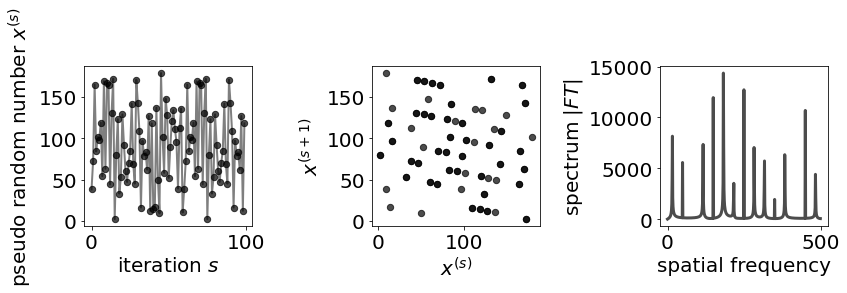

In [35]:
prng = PRNG(m=181, a=40, c=0, maximum=1000)
x = np.array(list(prng))
X = np.fft.fft(x)

kw = dict(s=40, color='k', alpha=0.7)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(np.arange(100), x[:100], **kw)
ax[0].plot(x[:100], color='k', lw=2, alpha=0.5)
ax[0].set_xlabel(r'iteration $s$')
ax[0].set_ylabel(r'pseudo random number $x^{(s)}$')
ax[1].scatter(x[:100], x[1:101], **kw)
ax[1].set_xlabel(r'$x^{(s)}$')
ax[1].set_ylabel(r'$x^{(s+1)}$')
ax[2].plot(np.abs(np.fft.fftshift(X))[1:len(x)//2], 
                  lw=3, color='k', alpha=0.7)
ax[2].set_xlabel('spatial frequency')
ax[2].set_ylabel(r'spectrum $|FT|$')
fig.tight_layout()

We can now analyze this LCG by using Markov chain methods. The recurrence relation (\ref{eq:LCG}) defines a Markov chain with deterministic transitions:

$$
P(x, y) = \left\{\begin{array}{c l}
1 \,\,;&x = (a y + c) \, \text{mod}\, m\\
0 \,\,;&\text{else}\\
\end{array}\right. 
$$

By evaluation of this relation for all pairs of states $x, y \in \{0, 1, \ldots, m-1\}$ we obtain a permutation matrix as transition matrix. (Permutation matrices are special doubly stochastic matrices: they just shuffle states around in a deterministic fashion.) 

In [36]:
prng._reset()

# construct transition matrix
P = np.zeros((prng.m, prng.m))
for j in range(prng.m):
    prng.x = j
    P[next(prng), j] = 1

# P is a permutation matrix, therefore 
# (see https://en.wikipedia.org/wiki/Permutation_matrix#Properties)

# 1. P has only entries in {0, 1}
assert np.allclose(np.sort(np.unique(P)), [0., 1.])

# 2. P is doubly stochastic
assert np.allclose(P.sum(0), 1)
assert np.allclose(P.sum(1), 1)

# 3. P is orthogonal
assert np.allclose(P.T @ P, np.eye(len(P)))
assert np.allclose(P @ P.T, np.eye(len(P)))

In [41]:
# Since P is a permutation matrix, all eigenvalues of P 
# are roots of one
v, U = np.linalg.eig(P)
assert np.all(np.isclose(np.abs(v), 1))

In [ ]:
# There are four stationary distributions
indices = np.where(np.isclose(v, 1.))[0]

print('#eigenvalues close to one:', len(indices))

U = U[:,indices].real
U /= U.sum(0)
U = U.T

# There is one trivially periodic state (x^{(0)}=0 with entropy 0)
# and there are three equally large subspaces
print('entropy of stationary distribution:', 
      np.round([- p @ np.log(p+1e-100) for p in U], 3))

In [44]:
np.sum(U[0]>0)

60

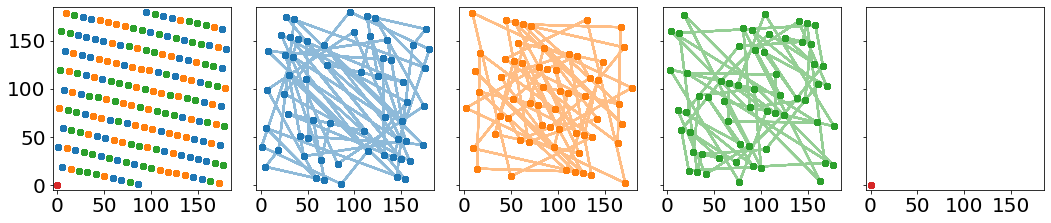

In [29]:
colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

orbits = []
ticks = (0, 50, 100, 150)
limits = (-5, prng.m+4)

fig, ax = plt.subplots(1, 5, figsize=(15, 3.5), sharex=True, sharey=True)

for i, u in enumerate(U):
    prng.seed = u.argmax()
    x = np.array(list(prng))
    orbits.append(set(x.tolist()))
    ax[0].scatter(x[:-1], x[1:], color=colors[i])
    ax[i+1].plot(x[:-1], x[1:], marker='o', alpha=0.5, lw=2, 
                 color=colors[i], ls='--')
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[0].set_xlim(limits)
ax[0].set_ylim(limits)
fig.tight_layout()

## Aperiodic Markov chains

The period of a state $x\in\mathcal X$ is defined as

\begin{equation}\label{eq:period}
d(x) = \text{gcd}\left\{s \ge 1 : P^s(x, x) > 0\right\} 
\end{equation}

where $\text{gcd}\{a_1, a_2, \ldots\}$ is the [greatest common divisor](https://en.wikipedia.org/wiki/Greatest_common_divisor) of the natural numbers $a_1, a_2, \ldots \in \mathbb N$. The period of a state $x$ is the greatest common divisor of the times that the chain can return (i.e. has positive probability of returning) to $x$, given that we start in $x$. 

A Markov chain is *aperiodic* if the periods of all states are one: $d(x) = 1$ for all $x\in\mathcal X$.  

So if a state is periodic, then the return times to $x$ are multiples of a factor greater than one, its period $d(x)$.  

Coming back to our two-state example, if we set $\alpha=\beta=1$ we have:

$$
P(x, y) = \begin{pmatrix}
0 & 1 \\
1 & 0\\
\end{pmatrix}
$$

For this Markov chain both states, $x_1$ and $x_2$, have a period of two, since the state is visited again after an even number of steps.  

![Periodic two-state model](images/twostate_periodic.png "Periodic two-state Markov model")

*In summary:*

* If a Markov chain is reducible, then it generates states only in a subspace of $\mathcal X$; which subspace is selected depends on the initial state. 

* If a Markov chain is periodic, then it cycles between multiple stationary distributions. 

### Illustration using the two-state system

We have

\begin{equation}\label{eq:twostate2}
P(x, y) = \begin{pmatrix}
1 - \alpha & \beta \\
\alpha & 1 - \beta \\
\end{pmatrix}
\end{equation}

with eigenvalues $1$ and $1-\alpha-\beta$ and corresponding (right) eigenvectors:

\begin{equation}\label{eq:twostate-decomposition}
\pi = \frac{1}{\alpha+\beta} \begin{pmatrix}
\beta \\ \alpha
\end{pmatrix}, \,\,\,
\text{and}\,\,\,  \begin{pmatrix}
1 \\ -1 \\
\end{pmatrix}
\end{equation}

assuming $\alpha>0$ or $\beta>0$. 

In case $\alpha=\beta=0$:

\begin{equation}\label{eq:twostate3}
P(x, y) = \begin{pmatrix}
1  & 0 \\
0 & 1  \\
\end{pmatrix}
\end{equation}

all two state distributions are stationary with eigenvalue one. In particular, we have eigenvectors

\begin{equation}\label{eq:decomposition2}
\begin{pmatrix}
1 \\ 0
\end{pmatrix}, \,\,\,
\begin{pmatrix}
0 \\ 1 \\
\end{pmatrix}
\end{equation}

corresponding to two recurrent classes, and $P$ is reducible.

In case $\alpha=\beta=1$:

\begin{equation}\label{eq:twostate4}
P(x, y) = \begin{pmatrix}
0  & 1 \\
1 & 0  \\
\end{pmatrix}
\end{equation}

the eigenvalues are $1$ and $-1$ with eigenvectors

$$
\begin{pmatrix}
1 \\ 1
\end{pmatrix}, \,\,\,
\begin{pmatrix}
1 \\ -1 \\
\end{pmatrix}
$$

and the chain is periodic: $P^{2s} = I$, $P^{2s+1} = P$.

# Lecture 5: The Metropolis-Hastings algorithm

## Outline

* Fundamental theorem of Markov chains
* Metropolis-Hastings algorithm

## Recap

* Idea: improve on direct sampling by allowing for dependence of successive samples (Markov property)

* Markov chains are defined by stochastic matrices; they have at least one stationary distribution

* Reducible and periodic chains will not converge to a unique stationary distribution 

So only if the Markov is both *irreducible* and *aperiodic*, then we have a unique stationary distribution. This is detailed in the following theorems.

## Fundamental Theorem of Markov Chains

Irreducibility and aperiodicity implies that $\pi$ is unique (see, for example, [Diaconis: The Markov Chain Monte Carlo Revolution](https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/)) and powers of $P$ converge to a rank one matrix

\begin{equation}\label{eq:fundamental}
P^S(x, y) \to \pi(x)
\end{equation}

for $S\to\infty$ and all $x, y \in\mathcal X$. Equation (\ref{eq:fundamental}) means that we can start from any initial state $y\in\mathcal X$ with $\pi(y) > 0$ and will eventually produce samples from the stationary distribution $\pi$. Another way to express this *convergence in distribution* is:

$$
|P^S p - \pi| \to 0
$$ 

for $S\to\infty$ for any $p$. That is, we can start from an arbitrary initial distribution and converge to the stationary distribution. In matrix-vector notation

$$
P^S \to \pi\mathbb 1^T\, .
$$

That is, if $P$ is irreducible and aperiodic, then matrix powers of $P$ converge to a rank-1 matrix. 

The fundamental theorem for Markov chains follows from the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) for non-negative matrices and the irreducibility of $P$. 

Why does theorem (\ref{eq:fundamental}) have implications for sampling? As we saw in the previous lectures, it might be difficult to sample a probabilistic model directly. Sometimes variable transformations allow us to sample a model directly, but this is only rarely the case for complex models. When resorting to rejection or importance sampling, it is generally difficult to find a good proposal distribution. On the other hand, simulation of a Markov chain is simple to implement (see algorithm above): we just have to move from $x$ to $y$ according to $P(y, x)$. No matter where we start in sample space, the states that we produce by simulating a Markov chain will eventually follow the stationary distribution. 

But there is still something missing in order to use the simulation of a Markov chain for probabilistic inference. In our setting, we are given a probabilistic model $p$ (our target distribution) rather than a transition matrix $P$. So we are still facing the challenge of designing a suitable Markov chain that has the desired target as its stationary distribution. This problem has been solved in a very ingenious fashion by Metropolis et al., as we will see soon. 

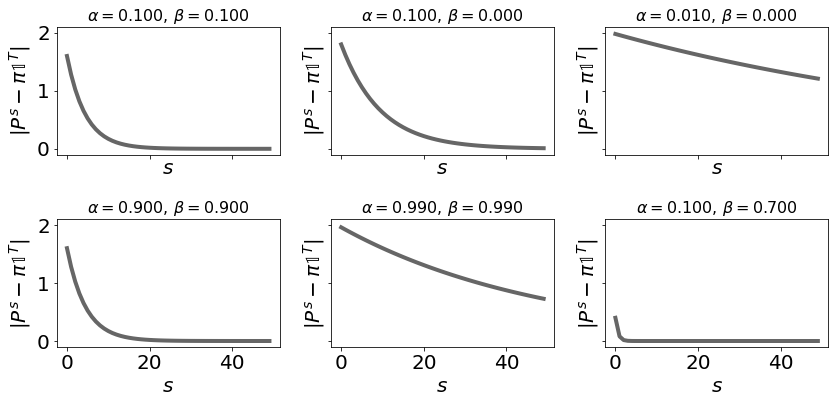

In [5]:
# matrix power converges to rank-1 matrix
def compute_pi(alpha, beta):
    return np.array([beta, alpha]) / (alpha + beta)

S = 50
chains = [(0.1, 0.1), (0.1, 0.), (1e-2, 0.), (0.9, 0.9), (0.99, 0.99), (0.1, 0.7)]

plt.rc('font', size=20)
kw = dict(ylim=[-0.1, 2.1], ylabel=r'$|P^s-\pi\mathbb{1}^T|$', xlabel='$s$')
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex='all', sharey='all', subplot_kw=kw)
ax = list(ax.flat)

for i, (alpha, beta) in enumerate(chains):

    P = transition_matrix(alpha, beta)
    pi = np.array([beta, alpha]) / (alpha + beta)
    P_inf = np.multiply.outer(pi, np.ones(2))
    P_s = P.copy()

    d = []
    while len(d)  < S:
        d.append(np.fabs(P_s - P_inf).sum())
        P_s = P_s.dot(P)

    ax[i].set_title(r'$\alpha={0:.3f}$, $\beta={1:.3f}$'.format(alpha, beta),
                   fontsize=16)
    ax[i].plot(d, lw=4, alpha=0.6, color='k')
fig.tight_layout()

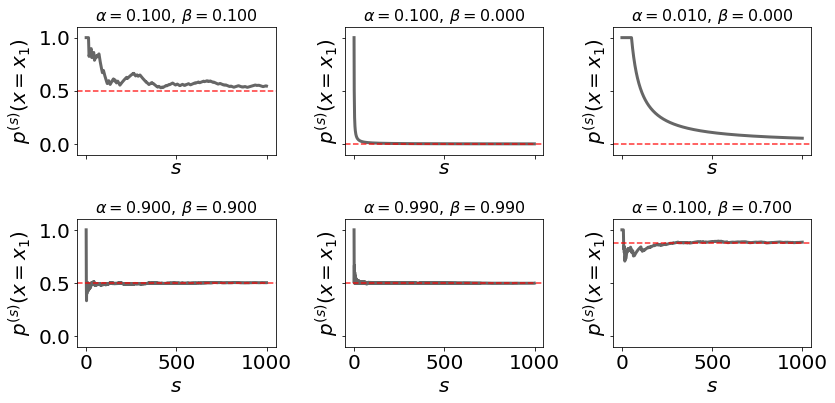

In [6]:
# convergence in distribution
def estimate_pi0(X):
    return 1-np.add.accumulate(X) / np.add.accumulate(np.ones(len(X)))

S = 1000

kw = dict(ylim=[-0.1, 1.1], ylabel=r'$p^{(s)}(x=x_1)$', xlabel='$s$')
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex='all', sharey='all', subplot_kw=kw)
ax = list(ax.flat)

for i, (alpha, beta) in enumerate(chains):
    X = sample_chain(S, alpha, beta, x0=0)
    pi = compute_pi(alpha, beta)
    pi_est = estimate_pi0(X)
    ax[i].set_title(r'$\alpha={0:.3f}$, $\beta={1:.3f}$'.format(alpha, beta),
                   fontsize=16)
    ax[i].plot(pi_est, lw=3, color='k', alpha=0.6)
    ax[i].axhline(pi[0], ls='--', color='r', alpha=0.8)
fig.tight_layout()

### Strong law of large numbers (LLN) for Markov chains

Before we explain the Metropolis algorithm, let us briefly state the convergence result for irreducible and aperiodic Markov chains in a fashion that is closer to the *Monte Carlo approximation* introduced in the first lecture.  

Irreducibility and aperiodicity of a stochastic transition matrix implies a strong law of large numbers for Markov chains: 

\begin{equation}\label{eq:lln_markov}
\frac{1}{S} \sum_{s=1}^S f\bigl(x^{(s)}\bigr) \to \mathbb E_{\pi}[f]
\end{equation}

where $x^{(s)} \sim \Pr\bigl(x\mid x^{(s-1)}\bigr) = P\bigl(x, x^{(s-1)}\bigr)$ is an irreducible, aperiodic Markov chain with stationary distribution $\pi$. Therefore, simulating a Markov chain produces samples that can be used to approximate an expectation similar to the approximation in standard Monte Carlo or importance sampling. 

Analogous to the standard Monte Carlo approximation, Markov chain Monte Carlo (MCMC) sampling produces estimates of expectations that coincide with the true expectation in the long run. Again, this is only a stochastic guarantee, and it will be generally difficult to know how close we are to the correct value. But nevertheless we have a guarantee that running a Markov chain longer should help. 

### Reversible Markov chains

A very important concept to verify stationarity of a Markov chain $P$ is *reversibility*. A Markov chain is *$\pi$-reversible* if the transition matrix satisfies the *detailed balance* equations

\begin{equation}\label{eq:reversible}
P(x, y)\, \pi(y) = P(y, x)\, \pi(x)
\end{equation}

for all $x, y \in \mathcal X$ for some distribution $\pi$. From the point of view of probability flow across the transition graph, the detailed balance equations (\ref{eq:reversible}) state that "the amount of probability mass flowing from a source state $x$ to a sink $y$ via the directed edge with capacity $P(y, x)$ equals the probability mass flowing backwards." So the dynamics across the transition graph is in a steady state. As a consequence, reversibility implies that $\pi$ is an invariant distribution:

\begin{equation}\label{eq:reversible_invariance}
\sum_{y\in\mathcal X} P(x, y)\pi(y) = \sum_{y\in\mathcal X} P(y, x) \pi(x) = \pi(x)\, .
\end{equation}

Therefore, to verify that a distribution of interest (our target distribution) is the invariant distribution of a Markov chain, we can simply check if the transition matrix satisfies detailed balance with respect to the target distribution. 

The contrary to (\ref{eq:reversible_invariance}) is __not__ true: The fact that $\pi$ is a stationary distribution of the transition matrix $P$ does not imply, that $P$ is $\pi$-reversible. 

If we start a Markov chain in the stationary distribution, $p^{(0)} = \pi$, then
\begin{eqnarray*}\label{eq:forward-backward}
\Pr\bigl(x_S = x^{(S)}, \ldots x_0=x^{(0)}\bigr) &=& 
\prod_{s=1}^S P\bigl(x^{(s)}, x^{(s-1)}\bigr)\,  \pi\bigl(x^{(0)}\bigr)\\
&=&
\prod_{s=1}^S P\bigl(x^{(s-1)}, x^{(s)}\bigr)\, \pi\bigl(x^{(S)}\bigr) \\
&=& \Pr\bigl(x_S = x^{(0)}, \ldots x_0=x^{(S)}\bigr)
\end{eqnarray*}

The probability of generating a Markov chain when starting in the stationary distribution is the same in forward and backward direction. This is why the Markov chain is called *reversible*.

If the transition matrix $P$ is symmetric, $P^T=P$, then the uniform distribution is the stationary distribution because the detailed balance equations are satisfied for $\pi(x) = 1/|\mathcal X|$. 

# The  Metropolis-Hastings Algorithm

We are now ready to discuss the [__Metropolis-Hastings algorithm__](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) which solves the following fundamental problem:

### For a given target distribution $p(x)$, how can we construct an irreducible and aperiodic Markov chain such that $p(x)$ is its stationary distribution?###


The Metropolis-Hastings algorithm solves this problem in a very elegant and simple fashion. Due to its simplicity, it is very widely applicable and ranks among the [top 10 algorithm of the 20th century](https://www.andrew.cmu.edu/course/15-355/misc/Top%20Ten%20Algorithms.html). 

## Algorithm: Metropolis-Hastings

Assume $\mathcal X$ is discrete and $p$ a pmf on $\mathcal X$. Moreover, $Q(y, x)$ is a proposal Markov chain on $\mathcal X$, that is $Q(\cdot, x)$ is a pmf on $\mathcal X$ that allows us to generate samples from a given state $x$. The trick of the Metropolis-Hastings algorithm is to modify the Markov chain $Q$, by auxiliary coin tossing, to a new transition kernel with stationary distribution $p$. 

The Metropolis-Hastings (MH) algorithm proceeds as follows:

Generate some initial $x^{(0)} \sim p^{(0)}$ and iterate for $s=1, 2, \ldots$:

1. propose a new state by generating $y \sim Q\bigl(\,\cdot\,, x^{(s-1)}\bigr)$

2. generate a uniform random number $u \sim \mathcal U(0, 1)$; if $u \le A\bigl(y, x^{(s-1)}\bigr)$ then *accept* and set $x^{(s)} = y$, else *reject* and set $x^{(s)} = x^{(s-1)}$. The acceptance probability is given by

\begin{equation}\label{eq:MHaccept}
A(y, x) = \min\left\{1, \frac{Q(x, y)}{Q(y, x)}\frac{p(y)}{p(x)} \right\}
\end{equation}


The MH algorithm is the first and most important Markov chain Monte Carlo (MCMC) algorithm. Most other MCMC algorithms are specialized versions of MH sampling. 

*Remarks*

1. The distribution $p$ will turn out to be a stationary distribution of the Markov chain that is simulated with the MH algorithm; $p$ is called the __target distribution__ or simply the __target__

2. The Metropolis-Hastings algorithm is also valid in continuous sample spaces $\mathcal X$

3. It is crucial to reject, i.e. to really duplicate the current state and store it as a sample in case of a rejected proposal. Otherwise the statistics will be wrong!

4. We don't need to build up and store the full transition matrix $Q$ of the proposal chain in memory. If $Q$ is symmetric, it suffices to be able to *simulate* $Q$ (this fact is used, for example, in Hamiltonian Monte Carlo where the proposal state is generated by solving a system of differential equations)

5. We don't need to know the normalizing constants of the target distribution and the proposal chain, since the MH algorithm only involves *ratios* of the target distribution and the transition rates of the proposal chain. If the unnormalized target and proposal chain are denoted 
    
    \begin{equation}\label{eq:unnormalized}
    p(x) = \frac{1}{Z_p} p^*(x), \,\,\, Q(x, y) = \frac{1}{Z_Q} Q^*(x, y)
    \end{equation}

where $p^*(x) \ge 0$ and $Z_p = \sum_x p^*(x)$ etc., then the *acceptance ratio* is

$$
\frac{Q(x, y)}{Q(y, x)}\frac{p(y)}{p(x)} = 
\frac{Q^*(x, y)}{Q^*(y, x)}\frac{Z_Q}{Z_Q}\, \frac{p^*(y)}{p^*(x)}\frac{Z_p}{Z_p}\, . 
$$

This is __very__ convenient!

## Special cases

* Symmetric proposal distribution $Q^T=Q$ (i.e. the stationary distribution of $Q$ is uniform). This was assumed in the original publication by [Metropolis *et al.*](https://aip.scitation.org/doi/abs/10.1063/1.1699114). The acceptance ratio simplifies to

$$
\frac{Q(x,y)\, p(y)}{Q(y, x)\, p(x)} = \frac{p(y)}{p(x)}
$$

Physicists tend to work with energies, i.e. negative log probabilities, rather than probabilities. So the logarithm 

$$
\Delta E = \log\{ p(x) / p(y) \}
$$

is the *energy difference* when jumping from state $x$ to the proposed state $y$. The acceptance probability is then

$$
\min\left\{1, e^{-\Delta E} \right\}
$$

If the energy of the new state is lower than the energy of the current state, the proposal is always accepted. Otherwise the acceptance probability depends on the [*Boltzmann factor*](https://en.wikipedia.org/wiki/Boltzmann_distribution) $\exp(-\Delta E)$.

* Independence sampler $Q(y, x) = q(y)$. The acceptance ratio simplifies to

$$
\frac{Q(x,y)\, p(y)}{Q(y, x)\, p(x)} = \frac{q(x)\, p(y)}{q(y)\, p(x)}
$$

If $q(x)$ is the target $q=p$, then we always accept and we are back to direct sampling $x\sim p$. 

There is also a connection to importance and rejection sampling. The importance weight of some state $x$ is

$$
w(x) = \frac{p(x)}{q(x)}\, ,
$$

and the acceptance ratio of the independence sampler involves ratios of importance weights

$$
\frac{w(y)}{w(x)}
$$

If the proposal state $y$ has a higher importance weight than the current state $x$, then we always accept. Otherwise the acceptance probability is $\min\{1, w(y)/w(x)\}$. So Metropolis sampling with an independent proposal is a kind of hybrid of rejection and importance sampling. Still it has some advantages over rejection sampling, since we do not need to establish an upper bound $M$ such that $p(x) \le Mq(x)$. In contrast to importance sampling, it has some built-in pruning because states that have a very small importance weight (relative to the current state) have only a small chance of being accepted.

## Why does the MH algorithm work?

The MH algorithm works because of the validity of the following statements:

### Transition probabilities of the MH algorithm

The MH algorithm generates a Markov chain on $\mathcal X$. The transition probabilities of the Markov chain are given by

\begin{equation}\label{eq:MHtransitions}
P(y, x) = Q(y, x)\, A(y, x) + \delta(y,x)\, r(x)
\end{equation}

where the acceptance probability $A(y, x)$ is defined above, and the rejection probability is

\begin{equation}\label{eq:MHrejection}
r(x) = 1 - \sum_{y\in \mathcal X} Q(y, x)\, A(y, x)
\end{equation}

The transition probability of $y\not= x$ is $A(y, x)\, Q(y, x)$ by construction of the algorithm. The term for $y=x$ is obtained by subtracting the sum $\sum_y A(y, x)\, Q(y, x)$ from one, which is just $r(x)$. In general, it holds that the diagonal entries of the transition matrix are fixed by column stochasticity: 

$$
1 = \sum_y P(y, x) \,\,\,\Rightarrow\,\,\, P(x, x) = 1 - \sum_{y\not= x} P(y, x)\, .
$$

So it is sufficient to know the off-diagonal elements. 

### Stationarity of the target distribution

To show that the target distribution $p(x)$ is indeed the stationary distribution of the Markov chain generated by the MH algorithm, we check if the transition matrix (\ref{eq:MHtransitions}) is $p$-reversible. For $y\not= x$ we have:
\begin{eqnarray*}\label{eq:MHreversible}
P(y, x)\, p(x) 
&=& Q(y, x)\, A(y, x)\, p(x) \\
&=& Q(y, x)\, \min\left\{1, \frac{Q(x, y)}{Q(y, x)}\frac{p(y)}{p(x)} \right\}\, p(x) \\
&=&\min\left\{ Q(y, x)\, p(x), Q(x, y)\, p(y) \right\}\\
&=& Q(x, y)\, \min\left\{1, \frac{Q(y, x)}{Q(x, y)}\frac{p(x)}{p(y)} \right\}\, p(y) \\
&=& Q(x, y)\, A(x, y)\, p(y) \\
&=& P(x, y)\, p(y)
\end{eqnarray*}

The MH chain satisfies the detailed balance equations with regard to our target distribution. Therefore, $p$ is a stationary distribution and will be sampled in the long run. 

To ensure that the simulation converges to $p$, we have to ensure irreducibility by proper choice of the proposal chain $Q(y, x)$. The proposal chain needs to be irreducible: every point $y \in \mathcal X$ is reachable from any $x \in\mathcal X$ in a finite number of steps.

## Example (Vihola, Example 6.19)

Let's run the MH algorithm on a simple staircase distribution with uniform proposals. The target distribution is

$$
p(x) = \frac{x}{Z}, \,\,\, x\in\{1, \ldots, m\}=:\mathcal X, \,\,\, Z=\sum_{x=1}^m x = m(m+1)/2
$$

To design an MH algorithm for simulating $p$, we have to choose a suitable proposal distribution. A simple choice is to use a uniform distribution over $\mathcal X$. That is, $Q(y, x)$ is independent of $x$ and $y$: $Q(y, x) = 1/m$ for all $x, y \in\mathcal X$. 

The resulting MH chain is irreducible:

$$
\Pr(x_1=y| x_0=x) = Q(y, x) \min\left\{1, \frac{Q(x, y)}{Q(y, x)}\frac{p(y)}{p(x)} \right\} = \frac{1}{m} \min\left\{1, \frac{y}{x}\right\} > 0
$$

for all $x, y\in\mathcal X$. We can get from from any $x\in \mathcal X$ to any $y$ within one step ($P(y,x) > 0$ for all $x, y$). 

The MH algorithm for this special case is very simple:

1. Pick $x^{(0)}$ uniformly in $\{1, \ldots, m\}$, e.g. $x^{(0)}=1$

2. Generate proposal $y \sim \mathcal U(\{1, \ldots, m\})$

3. Generate $u \sim \mathcal U(0, 1)$ and if $u \le \frac{y}{x^{(s-1)}}$, set $x^{(s)} = y$, otherwise $x^{(s)} = x^{(s-1)}$

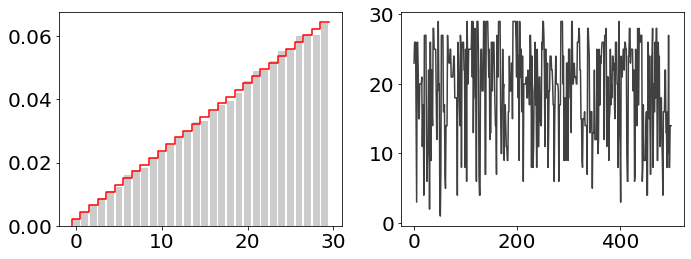

In [47]:
# Example 6.19 from Vihola's lecture notes
import numpy as np
import matplotlib.pylab as plt

# size of sample space
m = 30

# sample space
X = np.arange(m)

# target distribution
p = X + 1.
p *= 2 / m / (m+1)

# uniform proposal
Q = lambda x=None: np.random.choice(X)

x = Q()
samples = [x]

while len(samples) < 1e5:

    # proposal step
    y = Q(x)
    
    # acceptance probability
    A = p[y] / p[x]
    
    # accept / reject?
    u = np.random.uniform()
    x = y if (u <= A) else x
    
    samples.append(x)
    
bins, counts = np.unique(samples, return_counts=True)
counts = counts / float(counts.sum())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(bins, counts, color='k', alpha=0.2)
ax[0].step(np.append(-1,X) + 0.5, np.append(0,p), color='r')
ax[1].plot(samples[-500:], color='k', alpha=0.75)
fig.tight_layout()

## Pros and cons of MCMC

Pros:

* Very versatile framework: the Metropolis-Hastings algorithm allows us to simulate a Markov chain with a desired stationary distribution in a highly flexible manner. The requirements are much easier to satisfy than the requirements for importance or rejection sampling

* We introduce local correlations which allows the simulation to zoom into the relevant regions of sample space

Cons:

* We sample locally and pay the price of introducing correlations between successive samples. Local sampling might get stuck and ergodicity might be hard to achieve. 

* We don't know how far away we are from the stationary distribution and are only given statistical guarantees for convergence in the long run

## Geometric interpretation of the Metropolis-Hastings algorithm

The MH algorithm takes a base chain $Q$, the proposal chain, that does not yet have the desired target distribution $p$ and tweaks it in such a way that the new chain has the correct distribution. This is achieved by constructing a new chain $P$ that is $p$-reversible:

\begin{equation}\label{eq:p-reversible}
    P(x, y)\, p(y) = P(y, x)\, p(x)
\end{equation}

The mapping from $Q$ to $P$ involves the acceptance ratio

\begin{equation}\label{eq:acceptance-ratio}
    R(y, x) = \frac{Q(x, y)\, p(y)}{Q(y, x)\, p(x)}
\end{equation}

and is defined as

\begin{equation}\label{eq:metropolized}
P(y, x) = \left\{
\begin{array}{c c}
Q(y, x)\, \min\{1, R(y, x)\} & \text{ if } y\not= x \\
\sum_z Q(z, x) \bigl(1 - \min\{1, R(z, x)\}\bigr) & \text{ if } y=x\\ 
\end{array}\right.
\end{equation}

If $Q$ is irreducible, then $P$ is also irreducible. 

The acceptance ratio $R(y, x)$ (Eq. \ref{eq:acceptance-ratio}) assesses how unbalanced the proposal chain is, i.e. how strongly $Q$ deviates from $p$-reversibility. If $Q$ were already $p$-reversible, then the ratio $R$ would always be one, and the proposal would always be accepted. The larger $R(y, x)$ deviates from one, the more unbalanced is the proposal chain with regard to the target. Since $R(x, y) = 1 / R(y, x)$, a strong flux of probability in one direction, results in a reduced flux of probability in the backwards direction. 

To better understand how the mapping from some irreducible proposal chain $Q$ to a $p$-reversible Metropolis chain $P$ works, let me try to explain a very nice paper by [Billera & Diaconis: A Geometric Interpretation of the Metropolis-Hastings Algorithm](https://projecteuclid.org/euclid.ss/1015346318). This paper sets out to provide a global view on why the MH algorithm in some sense provides the optimal way of turning some arbitrary Markov chain $Q$ into a Markov chain with the desired stationary distribution. 

First let us think of the space of all possible Markov chains indexed by states from the finite sample space $\mathcal X$. This space is formed by left stochastic square matrices of size $|\mathcal X|$ and will be called $\mathcal S(\mathcal X)$. $\mathcal S(\mathcal X)$ is convex, because the convex combination of two Markov matrices is again a stochastic matrix. The dimension of $\mathcal S(\mathcal X)$ is $|\mathcal X|(|\mathcal X| -1 )$: there are $|X|^2$ non-negative entries in total from which we need to subtract $|X|$ diagonal entries that are fixed by column stochasticity (Eq. \ref{eq:leftstochastic}).

For a fixed target distribution $p$, the subset $\mathcal R(p)$ of all Markov matrices that are $p$-reversible 
\begin{equation}\label{eq:p-reversible-chains}
\mathcal R(p) = \left\{ P \in \mathcal S(\mathcal X): P(x, y)\, p(y) = P(y, x)\, p(x) \right\}
\end{equation}
has dimension $|\mathcal X|(|\mathcal X| - 1) / 2$, because $p$-reversibility (Eq. \ref{eq:p-reversible}) fixes a triangular portion of the transition matrix

$$
P(y, x) = P(x, y) \frac{p(y)}{p(x)}
$$

We can either choose $P(x, y)$ upon which $P(y, x)$ is fixed, or vice versa. $\mathcal R(p)$ is a convex subspace of $\mathcal S$: If $P, P' \in \mathcal R(p)$, then $\lambda P + (1-\lambda) P' \in \mathcal R(p)$ for $\lambda\in[0,1]$. 

To get a visual impression, let us display the relevant matrix spaces for sample spaces with only two states (Eq. \ref{eq:twostate}). Due to the stochasticity constraints, 2-state Markov chains can be represented by points in a two-dimensional unit square. The axes of this space are spanned by $\alpha = \Pr(x_2|x_1)$ and $\beta=\Pr(x_1|x_2)$. The $p$-reversible chains form a one-dimensional subspace

$$
\mathcal R(p) = \left\{(\alpha, \beta) \in [0,1]^2 : \beta = \frac{p(x_1)}{p(x_2)}\,\alpha  \right\}
$$

a straight line segment through the origin with slope $p(x_1)/p(x_2)$. 

The following figure shows $\mathcal{R}(p)$ for $p(x_1) = 0.4$, $p(x_2) = 1-p(x_1) = 0.6$.

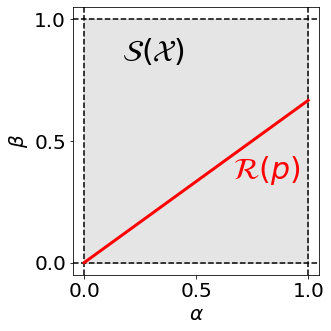

In [8]:
# 2D visualization

plt.rc('font', size=20)

def make_plot(p0=0.4, limits=(-0.05, 1.05), ax=None):
    
    kw = dict(xticks=[0.,0.5, 1.0], yticks=[0.,0.5, 1.0])
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=kw)
    else:
        fig = None
    alpha = beta = np.linspace(0., 1., 100)
    ax.fill_between(alpha, beta*0., beta*0.+1, color='k', alpha=0.1)
    ax.axvline(1., ls='--', color='k')
    ax.axhline(1., ls='--', color='k')
    ax.axvline(0., ls='--', color='k')
    ax.axhline(0., ls='--', color='k')
    ax.plot(alpha, alpha*p0/(1-p0), lw=3, color='r')
    ax.annotate(r'$\mathcal{S}(\mathcal{X})$', (.2, .8), xycoords='axes fraction', fontsize=30)
    ax.annotate(r'$\mathcal{R}(p)$', (.65, .36), color='r', xycoords='axes fraction', fontsize=30)
    ax.set_xlim(*limits)
    ax.set_ylim(*limits)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    if fig:
        fig.tight_layout()

    return fig, ax


p0 = 0.4
fig, ax = make_plot(p0)
fig.tight_layout()

The Metropolis-Hastings algorithm maps an irreducible proposal chain $Q$ to $\mathcal R(p)$

\begin{equation}\label{eq:Metropolis-map}
M[Q](y, x) = \min\left\{Q(y, x), \frac{p(y)}{p(x)}\,Q(x, y) \right\}
\end{equation}

for $y\not= x$ (the diagonal entries are fixed by column stochasticity (Eq. \ref{eq:leftstochastic})). The function $M: \mathcal S(\mathcal X) \to \mathcal R(p)$ is called *Metropolis map*. For a two-state system, the map is simply

$$
\begin{pmatrix}
\alpha \\ \beta 
\end{pmatrix} \to
\min\bigl\{\alpha\, p(x_1), \beta\, (1-p(x_2)) \bigr\}
\begin{pmatrix}
1 / p(x_1) \\ 1 / p(x_2)
\end{pmatrix}
$$

Examples for the Metropolis map are shown in the following figure:

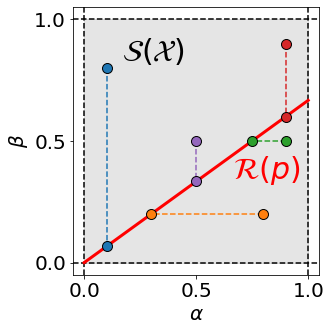

In [9]:
def M(p0, alpha, beta):
    alpha_new = min(alpha, (1-p0) * beta / p0) 
    beta_new = min(beta, p0 * alpha / (1-p0))
    return alpha_new, beta_new

fig, ax = make_plot(p0)
for Q in [(0.1, 0.8), (0.8, 0.2), (0.9, 0.5), (0.9, 0.9), (0.5, 0.5)]:
    P = M(p0, *Q)
    ax.plot([Q[0],P[0]],[Q[1],P[1]], ls='--', marker='o', markersize=10,
            markeredgecolor='k')
fig.tight_layout()

By construction, the off-diagonal entries in the Metropolis chain $M[Q]$ are *coordinate-wise decreasing*:

\begin{equation}\label{eq:coordinatewise-decreasing}
M[Q](y, x) \le Q(y, x)\,\,\,\text{for all}\,\, x, y \in \mathcal X \, .
\end{equation}

In the above figure, $Q$ is either shifted to the left along the $\alpha$ axis, i.e. towards smaller $P(x_2, x_1)$ values until $\mathcal{R}(p)$ is hit, or $Q$ is shifted downwards long the $\beta$ axis. 

A suitable metric on $\mathcal S(\mathcal{X})$ is

\begin{equation}\label{eq:metric}
d(P, P') = \sum_{x\in\mathcal{X}} \sum_{y\not= x} p(x)\, \left|P(y, x) - P'(y, x)\right|
\end{equation}

which is only zero, if $P'=P$. The following figure shows "circles" around some $Q\in\mathcal S(\mathcal X)$ which are of course not actual circles because $d(P,P')$ is a weighted L1 norm, so $d$-circles are diamonds.  

For the 2-state system, we have

$$
d(P, P') = p(x_1)\, |\alpha - \alpha'| + p(x_2)\, |\beta - \beta'|
$$

where $\alpha, \alpha'$ etc. are the off-diagonal entries of the transition matrices $P, P'$.  

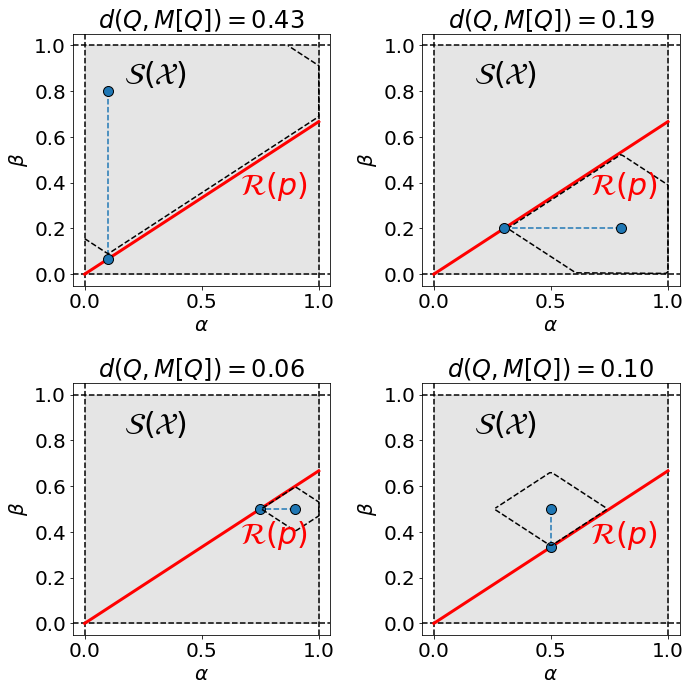

In [10]:
def distance(p, P, Q):
    M = 1 - np.eye(len(p))
    return np.sum(np.fabs(P-Q)*M*p)


def circle(p0, Q, factor=0.95):

    P = M(p0, *Q)
    A = transition_matrix(*Q)
    B = transition_matrix(*P)

    p = np.array([p0, 1-p0])                          
    d = distance(p, A, B) * factor

    alpha = np.linspace(0., 1., 100)
    beta = (d - np.fabs(alpha-Q[0]) * p0) / (1-p0)
    mask = beta >= 0
    alpha = alpha[mask]
    beta = beta[mask]
    
    alpha = np.append(alpha, alpha[::-1])
    beta = np.append(Q[1]-beta, Q[1]+beta[::-1])
    
    mask = np.logical_and(beta >= 0, beta <= 1)

    return d, alpha[mask], beta[mask]
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = list(ax.flat)
counter = 0
for Q in [(0.1, 0.8), (0.8, 0.2), (0.9, 0.5), (0.5, 0.5)][:4]:
    make_plot(p0, ax=ax[counter])
    P = M(p0, *Q)
    R = Q[1] * p0 / (1-p0) / Q[0]
    ax[counter].set_title(r'$|\log R| = {0:.1f}$'.format(np.fabs(np.log(R))))
    ax[counter].plot([Q[0],P[0]],[Q[1],P[1]], ls='--', marker='o', markersize=10,
            markeredgecolor='k')
    d, alpha, beta = circle(p0, Q, 0.97)
    ax[counter].set_title(r'$d(Q,M[Q]) = {0:.2f}$'.format(d))
    ax[counter].plot(alpha, beta, color='k', ls='--')
    counter += 1
fig.tight_layout()

Billera and Diaconis demonstrate that the Metropolis map minimizes the distance $d(Q,P)$ between the proposal chain $Q$ and all $P\in\mathcal{R}(p)$. Among all minimizers in the set of $p$-reversible chains, it picks the unique element that is coordinate-wise decreasing (Eq. \ref{eq:coordinatewise-decreasing}). It makes sense to demand that the mapping is coordinate-wise decreasing, because otherwise it will be more difficult to guarantee that the mapped chain is still in $\mathcal S(\mathcal X)$. 

### Variations of Metropolis-Hastings

Given a proposal chain $Q$, our goal is to change it to a chain with stationary distribution $p(x)$. The new chain should work as follows: 

* Propose $y \sim Q(\cdot, x)$ 

* Accept or reject $y$ as new $x$ with probability $A(y, x)\in[0,1]$ 

The transition probabilities of the new chain will be

$$
Q(y, x)\, A(y, x)\,\,\,\text{for}\,\, y\not= x \, .
$$

Again, the diagonal entries a fixed by column stochasticity. To impose stationarity with regard to our target, we demand that the new chain is $p$-reversible:

$$
Q(y, x)\, A(y, x)\, p(x) = Q(x, y)\, A(x, y)\, p(y)
$$

which gives us

$$
A(y, x) = \frac{Q(x, y)}{Q(y, x)}\frac{p(y)}{p(x)}\, A(x, y) = R(y, x)\, A(x, y)\, .
$$

Since $A(y, x) \in [0, 1]$ is a probability, it follows that

$$
A(x, y) = \frac{1}{R(y, x)} \, A(y, x) \le 1 \,\,\,\Rightarrow\,\,\,
A(y, x) \le R(y, x)
$$

Combined with $A(y, x)\le 1$, we have

$$
A(y, x) \le \min\left\{1, R(y, x)\right\}
$$

That is, the acceptance probability of any propose-accept scheme is smaller than or equal to the acceptance probability of the Metropolis-Hastings algorithm. The MH algorithm maximizes the chance of moving away from $x$. 

Other choices for $A(y, x)$ have been proposed. These are typically of the form $A(y, x) = f(R(y, x))$ where

$$
0 \le f(r) \le \min\left\{1, r \right\},\,\,\, r\ge 0 
$$

For example, Barker's algorithm uses a sigmoidal function $f(r) = r / (1 + r)$ such that

$$
A(y, x) = \frac{R(y, x)}{1 + R(y, x)}
$$

An early investigation into different acceptance probabilities is: [Peskun, P. H. (1973). Optimum Monte Carlo sampling using Markov chains. Biometrika, 60:607–612.](https://academic.oup.com/biomet/article/60/3/607/217255)

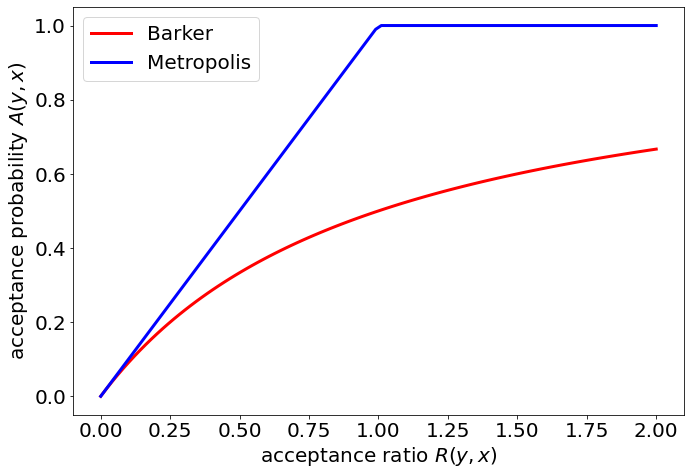

In [11]:
# Barker's acceptance probability

R = np.linspace(0., 2., 100)
acc_barker = R / (1 + R)
acc_metropolis = np.clip(R, 0., 1.)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(R, acc_barker, color='r', label='Barker', lw=3)
ax.plot(R, acc_metropolis, color='b', label='Metropolis', lw=3)
ax.set_xlabel(r'acceptance ratio $R(y, x)$')
ax.set_ylabel(r'acceptance probability $A(y, x)$')
ax.legend()
fig.tight_layout()

### Metropolis-Hastings in continuous sample spaces

The MH algorithm works also for continuous sample space where $p$ is a pdf and $Q(y, x)$ is a Markov kernel. The following example uses a uniform proposal kernel

$$
Q(y, x) = \mathcal U(x - \epsilon, x + \epsilon)
$$

with $\epsilon > 0$ being a step size. Since $Q(y, x) = Q(x, y)$, the acceptance ratio simplifies to $p(y)/p(x)$. Let us try to sample from the standard Gaussian distribution

$$
p(x) \propto \exp\left\{-\frac{1}{2} x^2 \right\}
$$

acceptance rate: 96.6% (stepsize = 1.00e-01)
acceptance rate: 80.5% (stepsize = 1.00e+00)
acceptance rate: 15.9% (stepsize = 1.00e+01)


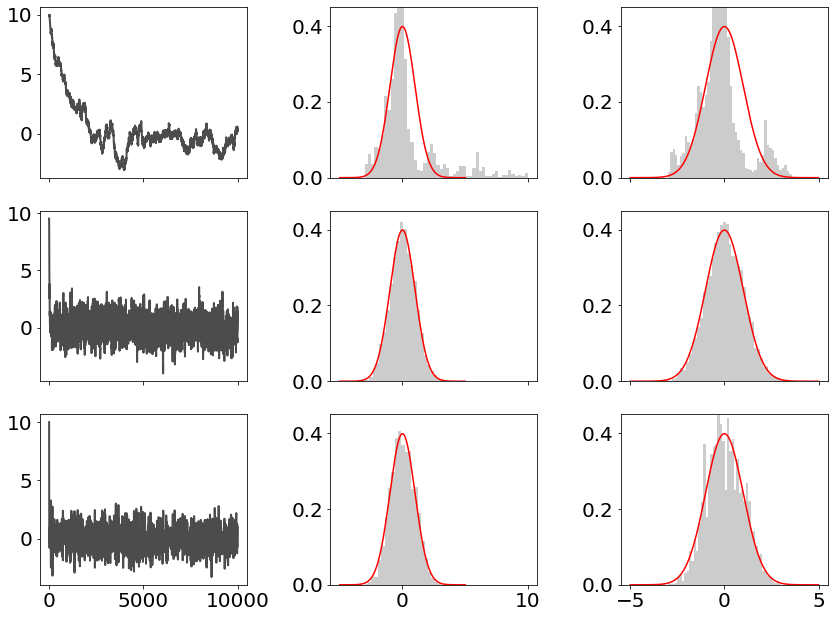

In [12]:
# sampling a standard Gaussian with a uniform proposal

class MetropolisHastings:
    
    def __init__(self, x, p, Q, S=1e4):
        """
        Parameters
        ----------
        x : initial state
        p : target distribution
        Q : simulator of a symmetric proposal chain
        S : number of samples
        """
        self.p = p
        self.Q = Q
        self.S = S
        self._initial = x
        
    def _reset(self):
        self._counter = 0
        self.n_accepted = 0
        self.x = self._initial
        
    @property
    def acceptance_rate(self):
        return self.n_accepted / self._counter
        
    def __next__(self):
        
        if self._counter >= self.S:
            raise StopIteration
            
        y = self.Q(self.x)
        u = np.random.uniform()
        
        if u <= self.p(y) / self.p(self.x):
            self.x = y
            self.n_accepted += 1
        self._counter += 1
        
        return self.x
    
    def __iter__(self):
        self._reset()
        return self
    
# target
p = lambda x: np.exp(-x**2/2)
t = np.linspace(-1, 1., 1000) * 5
target = t, p(t) / np.sqrt(2*np.pi)

# proposal
Q = lambda x, eps=0.1: np.random.uniform(x-eps, x+eps)

S = 1e4
x = 10.

fig, ax = plt.subplots(3, 3, figsize=(12, 9), sharex='col')

for i, eps in enumerate([1e-1, 1e0, 1e1]):

    # run MH simulation
    mh = MetropolisHastings(x, p, lambda x: Q(x, eps), S)
    samples = np.array(list(mh))
    
    print('acceptance rate: {0:.1%} (stepsize = {1:.2e})'.format(
        mh.acceptance_rate, eps))
    
    # plot results
    ax[i,0].plot(samples, color='k', lw=2, alpha=0.7)
    ax[i,1].hist(samples, bins=50, density=True, alpha=0.2, color='k')
    ax[i,2].hist(samples[1000:], bins=50, density=True, alpha=0.2, color='k')
    for a in ax[i,1:]:
        a.plot(*target, color='r')
        a.set_ylim(0., 0.45)
fig.tight_layout()

# Lecture 6: Gibbs sampling

Michael Habeck - University Hospital Jena - michael.habeck@uni-jena.de

## Outline

* Recap: Metropolis-Hastings algorithm
* Combining Markov chains
* Gibbs sampling
* Auxiliary variable methods

# Recap

* Markov chain Monte Carlo (MCMC) algorithms simulate a Markov chain to generate samples from a target distribution $p$

* The Metropolis-Hastings (MH) algorithm is a very general scheme to generate a *reversible* Markov chain whose stationary distribution is a desired target distribution

## Metropolis-Hastings Algorithm

The MH algorithm allows us to map (almost) any Markov chain $Q$ (the *proposal chain*) with whatever stationary distribution to a Markov chain $M[Q]$ (the *Metropolis map* of $Q$) that has the desired stationary distribution, our target distribution $p$. We have

$$
M[Q](y, x) = \min\left\{Q(y, x), Q(x, y)\frac{p(y)}{p(x)} \right\} \,\,\, \text{for}\,\,\, y\not=x\, . 
$$

By construction, the Metropolis map is coordinate-wise decreasing, $M[Q](y, x) \le Q(y, x)$. Among all maps that implement a *propose-accept/reject* scheme, $M[Q]$ *maximizes* the probability of moving from a current state to a new state proposed by $Q$. The Metropolis map projects the proposal chain $Q$ onto the subspace $\mathcal{R}(p)$ of $p$-reversible Markov chains. The projection minimizes the distance $d(P,P') = \sum_{x\in\mathcal X} \sum_{y\not= x} p(x) |P(y, x) - P'(y, x)|$, and identifies $M[Q]\in\mathcal{R}(p)$ uniquely by demanding that the map is coordinate-wise decreasing.  

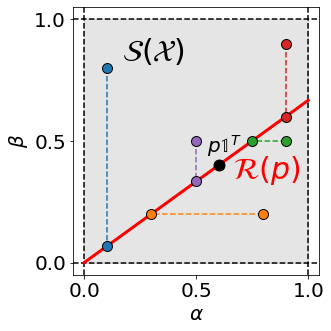

In [13]:
# 2D visualization

plt.rc('font', size=20)

def make_plot(p0=0.4, limits=(-0.05, 1.05), ax=None):
    
    kw = dict(xticks=[0.,0.5, 1.0], yticks=[0.,0.5, 1.0])
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=kw)
    else:
        fig = None
    alpha = beta = np.linspace(0., 1., 100)
    ax.fill_between(alpha, beta*0., beta*0.+1, color='k', alpha=0.1)
    ax.axvline(1., ls='--', color='k')
    ax.axhline(1., ls='--', color='k')
    ax.axvline(0., ls='--', color='k')
    ax.axhline(0., ls='--', color='k')
    ax.plot(alpha, alpha*p0/(1-p0), lw=3, color='r')
    ax.annotate(r'$\mathcal{S}(\mathcal{X})$', (.2, .8), xycoords='axes fraction', fontsize=30)
    ax.annotate(r'$\mathcal{R}(p)$', (.65, .36), color='r', xycoords='axes fraction', fontsize=30)
    ax.set_xlim(*limits)
    ax.set_ylim(*limits)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    if fig:
        fig.tight_layout()

    return fig, ax


def M(p0, alpha, beta):
    alpha_new = min(alpha, (1-p0) * beta / p0) 
    beta_new = min(beta, p0 * alpha / (1-p0))
    return alpha_new, beta_new

p0 = 0.4
fig, ax = make_plot(p0)
for Q in [(0.1, 0.8), (0.8, 0.2), (0.9, 0.5), (0.9, 0.9), (0.5, 0.5)]:
    P = M(p0, *Q)
    ax.plot([Q[0],P[0]],[Q[1],P[1]], ls='--', marker='o', markersize=10,
            markeredgecolor='k')
ax.scatter(1-p0, p0, s=120, color='k', zorder=5)
ax.annotate(r'$p\mathbb{1}^T$', (1-p0-0.05, p0+0.05))
fig.tight_layout()

## Algorithmic parameters

Algorithmic parameters such as the step size used in the proposal chain can have a strong effect on the performance of MH sampling. We will later discuss *adaptive* MCMC algorithms that can tune some of these parameters in a sound fashion. 

acceptance rate: 97.0% (stepsize = 1.00e-01)
acceptance rate: 80.5% (stepsize = 1.00e+00)
acceptance rate: 16.2% (stepsize = 1.00e+01)


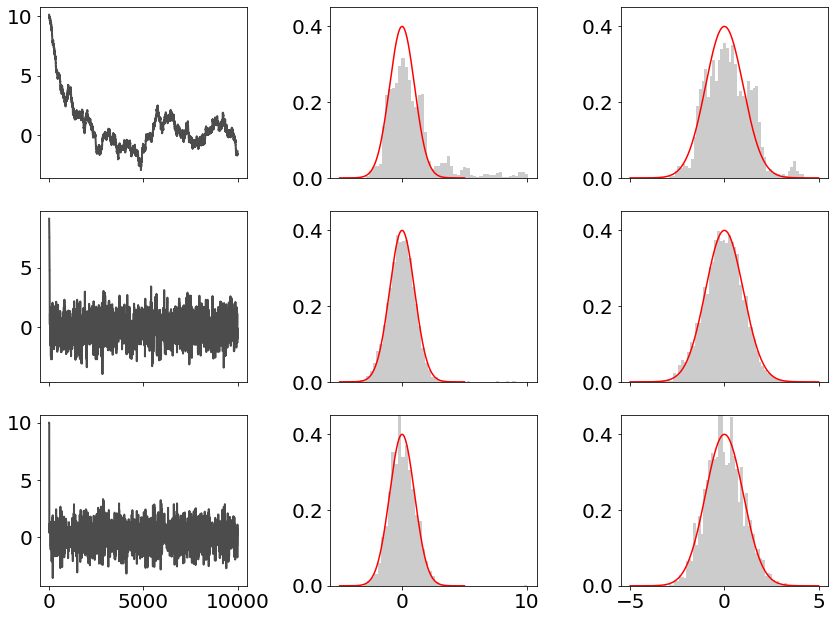

In [14]:
# sampling a standard Gaussian with a uniform proposal

class MetropolisHastings:
    
    def __init__(self, x, p, Q, S=1e4):
        """
        Parameters
        ----------
        x : initial state
        p : target distribution
        Q : simulator of a symmetric proposal chain
        S : number of samples
        """
        self.p = p
        self.Q = Q
        self.S = S
        self._initial = x
        
    def _reset(self):
        self._counter = 0
        self.n_accepted = 0
        self.x = self._initial
        
    @property
    def acceptance_rate(self):
        return self.n_accepted / self._counter
        
    def __next__(self):
        
        if self._counter >= self.S:
            raise StopIteration
            
        y = self.Q(self.x)
        u = np.random.uniform()
        
        if u <= self.p(y) / self.p(self.x):
            self.x = y
            self.n_accepted += 1
        self._counter += 1
        
        return self.x
    
    def __iter__(self):
        self._reset()
        return self
    
# target
p = lambda x: np.exp(-x**2/2)
t = np.linspace(-1, 1., 1000) * 5
target = t, p(t) / np.sqrt(2*np.pi)

# proposal
Q = lambda x, eps=0.1: np.random.uniform(x-eps, x+eps)

S = 1e4
x = 10.

fig, ax = plt.subplots(3, 3, figsize=(12, 9), sharex='col')

for i, eps in enumerate([1e-1, 1e0, 1e1]):

    # run MH simulation
    mh = MetropolisHastings(x, p, lambda x: Q(x, eps), S)
    samples = np.array(list(mh))
    
    print('acceptance rate: {0:.1%} (stepsize = {1:.2e})'.format(
        mh.acceptance_rate, eps))
    
    # plot results
    ax[i,0].plot(samples, color='k', lw=2, alpha=0.7)
    ax[i,1].hist(samples, bins=50, density=True, alpha=0.2, color='k')
    ax[i,2].hist(samples[1000:], bins=50, density=True, alpha=0.2, color='k')
    for a in ax[i,1:]:
        a.plot(*target, color='r')
        a.set_ylim(0., 0.45)
fig.tight_layout()

In the next example, we run the MH algorithm on a continuous pdf in two dimensions. 

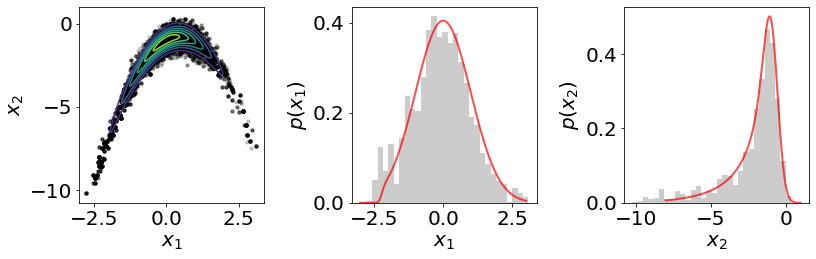

In [15]:
"""
Metroplis sampling of a banana-shaped pdf
"""
import numpy as np
import matplotlib.pylab as plt

from scipy.special import logsumexp

class Banana:

    def __init__(self):

        self.C = np.array([[1., 0.9],
                           [0.9, 1.]])
        
        self.C_inv = np.array([[100., -90.],
                               [-90, 100.]]) / 19.

        self.a = 1
        self.b = 1
        
    def __call__(self, x):

        if x.ndim == 2:
            x1, x2 = x.T
        else:
            x1, x2 = x

        a, b = self.a, self.b
            
        y = np.transpose([x1 / a, a * x2 + a * b * (x1**2 + a)])

        logp = -0.5 * np.sum(y.dot(self.C_inv.T) * y, -1)

        return logp

def compute_marginal(pdf2d, axis=0, vals=None):

    marginal = logsumexp(pdf2d, axis=axis)
    marginal -= logsumexp(marginal)

    if vals is not None:
        marginal -= np.log(vals[1]-vals[0])

    return marginal


Q = lambda x, eps=1.: x + np.random.standard_normal(2) * eps
p = Banana()

x = np.zeros(2)
p_x = p(x)

samples = [x]

while len(samples) < 1e4:

    y = Q(x)
    p_y = p(y)
    
    accept = np.log(np.random.uniform()) < p_y - p_x
    if accept:
        x, p_x = y, p_y

    samples.append(x)

samples = np.array(samples)

# plot results

x = np.linspace(-3., 3., 200)
y = np.linspace(-8., 1., len(x))
grid = np.reshape(np.meshgrid(x, y), (2, -1)).T
pdf = p(grid).reshape(len(x), len(y))

pdf_x = compute_marginal(pdf, axis=0, vals=x)
pdf_y = compute_marginal(pdf, axis=1, vals=y)

kw_hist = dict(bins=30, color='k', alpha=0.2, density=True)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#
ax[0].contour(x, y, np.exp(pdf))
ax[0].scatter(*samples.T, color='k', alpha=0.2, s=10)
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
#
ax[1].hist(samples[:,0], **kw_hist)
ax[1].plot(x, np.exp(pdf_x), color='r', alpha=0.7, lw=2)
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$p(x_1)$')
#
ax[2].hist(samples[:,1], **kw_hist)                       
ax[2].plot(y, np.exp(pdf_y), color='r', alpha=0.7, lw=2)
ax[2].set_xlabel(r'$x_2$')
ax[2].set_ylabel(r'$p(x_2)$')
#
fig.tight_layout()

# Combining Markov Chains

Let $P_i$ be $N$ Markov chains that share the same stationary distribution $\pi$:

\begin{equation}\label{eq:multiple_chains}
P_i \pi = \pi, \,\,\, \mathbb{1}^T\!P_i = \mathbb{1}^T
\end{equation}

The product of all chains, $P=\prod_i P_i$ (here $\prod_i$ symbolizes a *matrix product*), is also a Markov chain with the same stationary distribution:

\begin{equation}\label{eq:product_chain}
P\pi = \pi, \,\,\, \mathbb{1}^T\!P = \mathbb{1}^T
\end{equation}

Therefore, the following algorithm will simulate $P$ and therefore eventually $\pi$:

\begin{align}\label{eq:markov-sequence}
\begin{split}
  \tilde{x}^{(1)} &\sim P_1\bigl(\,\cdot\,, x^{(s)}\bigr) \\
  \tilde{x}^{(2)} &\sim P_2\bigl(\,\cdot\,, \tilde{x}^{(1)}\bigr) \\
  & \vdots   \\
  x^{(s+1)} &\sim P_N\bigl(\,\cdot\,, \tilde{x}^{(N-1)}\bigr) \\
\end{split}
\end{align}


## Coordinate-wise sampling

Let's look at a special but important case. Assume that the sample space decomposes into a product of $N$ sample spaces $\mathcal X = \mathcal X_1 \times \cdots \times \mathcal X_N$ with associated variables $x_i$ ($i=1, \ldots, N$)  where $x_i$ denotes a single variable or a group of variables that will be sampled jointly. The joint distribution of all variables is $p(x) = p(x_1, \ldots, x_N)$. 

By $x_{\setminus i}$ we denote the variable vector obtained by omitting the $i$-th variable (or group of variables):

\begin{equation}\label{eq:without-group}
x_{\setminus i} := \begin{pmatrix}x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_N \end{pmatrix}
\end{equation}

Then $x_{\setminus i}$ follows the marginal distribution:

\begin{equation}\label{eq:without-group-marginal}
p_{\setminus i}(x_{\setminus i}) = \int p(x_1, \ldots, x_N)\, d x_i
\end{equation}

The marginal distribution of $x_i$ is:

\begin{equation}\label{eq:group-marginal}
p_{i}(x_{i}) = \int p(x_1, \ldots, x_N)\, d x_{\setminus i}
\end{equation}

The conditional distribution of $x_i$ also readily available:

\begin{equation}\label{eq:group-conditional}
p_{i}(x_{i}|x_{\setminus i}) = \frac{p(x)}{p_{\setminus i}(x_{\setminus i})}
\end{equation}

Let us consider a sequence of $N$ Markov chains $P_i$ where each chain only updates $x_i$ and does not change $x_{\setminus i}$:

\begin{equation}\label{eq:chain-group}
Q_i(y, x) = q_i(y_i, x_i; x_{\setminus i})\, \delta(y_{\setminus i} - x_{\setminus i})  
\end{equation}

where we introduced a product of delta distributions:

$$
\delta(x_{\setminus i}) := \prod_{j\not= i} \delta(x_j)
$$

and $q_i(y_i, x_i; x_{\setminus i})$ is a Markov kernel on $\mathcal X_i \times \mathcal X_i$ with $x_{\setminus i}$ being treated like a set of parameters. 

The Metropolis map of $Q_i(y, x)$ is

\begin{align}\label{eq:coordinatewise-map}
\begin{split}
M[Q_i](y, x) 
&= \min\left\{Q_i(y, x), Q_i(x, y) \frac{p(y)}{p(x)} \right\} \\
&= \delta(y_{\setminus i}-x_{\setminus i})\, \min\left\{q_i(y_i, x_i; x_{\setminus i}), q_i(x_i, y_i; x_{\setminus i}) \frac{p_i(y_i|y_{\setminus i})\,p_{\setminus i}(y_{\setminus i})}{p_i(x_i | x_{\setminus i}) p_{\setminus i}(x_{\setminus i})} \right\} \\
&= \delta(y_{\setminus i}-x_{\setminus i})\, \min\left\{q_i(y_i, x_i; x_{\setminus i}), q_i(x_i, y_i; x_{\setminus i}) \frac{p_i(y_i|x_{\setminus i})}{p_i(x_i | x_{\setminus i})} \right\}
\end{split}
\end{align}

If we run the Metropolis-Hastings algorithm with $Q_i$, we simulate a Markov chain only on the conditional distribution of the $i$-th variable (or group of variables). This involves a Markov kernel $q_i$ on the corresponding subspace $\mathcal X_i$ that could, in principle, depend on all of the current variables. 

This produces a Markov chain with the correct stationary distribution, but since $Q_i$ changes only the $i$-th variable, the resulting Markov chain is not ergodic. The trick is to update each parameter group successively using $Q_i$ in each subspace $\mathcal X_i$, and thereby produce a sequence of Metropolis maps, $M[Q_i]$, that share a common target distribution. Simulation of $M[Q_i]$ one after the other generates a simulation of the product chain, in a fashion analogous to equation (\ref{eq:markov-sequence}). This scheme is sometimes called *Metropolis-within-Gibbs*. 

Let's apply the coordinate-wise sampling scheme to the banana-shaped distribution using uniform proposals in each direction:

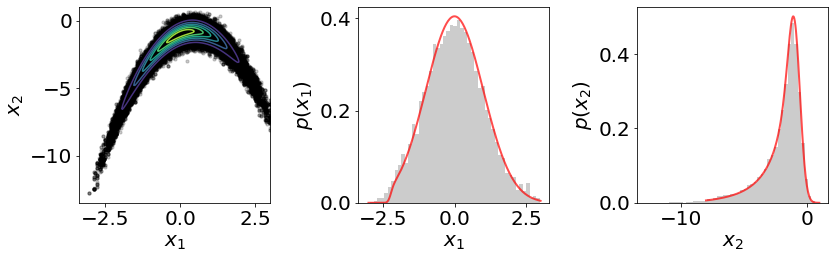

In [16]:
p = Banana()
Q = []
for i in range(2):
    Q_i = lambda x, i=i, eps=2.: \
    x + eps * np.random.uniform(-1.,1.,2) * np.eye(2)[i]
    Q.append(Q_i)
    
x = np.zeros(2)
p_x = p(x)

samples = [x]

while len(samples) < 1e5:

    for Q_i in Q:
        y = Q_i(x)
        p_y = p(y)
        accept = np.log(np.random.uniform()) < p_y - p_x
        if accept:
            x, p_x = y, p_y

    samples.append(x)

samples = np.array(samples)
samples = samples[int(0.2*len(samples)):]

# plot results

x = np.linspace(-3., 3., 200)
y = np.linspace(-8., 1., len(x))
grid = np.reshape(np.meshgrid(x, y), (2, -1)).T
pdf = p(grid).reshape(len(x), len(y))

pdf_x = compute_marginal(pdf, axis=0, vals=x)
pdf_y = compute_marginal(pdf, axis=1, vals=y)

kw_hist = dict(bins=50, color='k', alpha=0.2, density=True)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#
ax[0].contour(x, y, np.exp(pdf))
ax[0].scatter(*samples.T, color='k', alpha=0.2, s=10)
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
#
ax[1].hist(samples[:,0], **kw_hist)
ax[1].plot(x, np.exp(pdf_x), color='r', alpha=0.7, lw=2)
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$p(x_1)$')
#
ax[2].hist(samples[:,1], **kw_hist)                       
ax[2].plot(y, np.exp(pdf_y), color='r', alpha=0.7, lw=2)
ax[2].set_xlabel(r'$x_2$')
ax[2].set_ylabel(r'$p(x_2)$')
#
fig.tight_layout()

# Gibbs sampling

[__Gibbs sampling__](https://en.wikipedia.org/wiki/Gibbs_sampling) is a simple and powerful MCMC method that can be interpreted as a special variant of the component-wise MH algorithm outlined above. Gibbs sampling assumes that we can sample directly from the conditional distributions $p_i(x_i | x_{\setminus i})$, and uses these as component-wise Markov chains:

$$
q_i(y_i, x_i; x_{\setminus i}) = p_i(y_i | x_{\setminus i})
$$

The acceptance ratio in the Metropolis map $M[Q_i]$ (Eq. \ref{eq:coordinatewise-map}) simplifies to 

$$
\frac{q_i(x_i, y_i; x_{\setminus i})}{q_i(y_i, x_i; x_{\setminus i})} \frac{p_i(y_i|x_{\setminus i})}{p_i(x_i|x_{\setminus i})} =
\frac{p_i(x_i | x_{\setminus i})}{p_i(y_i | x_{\setminus i})} \frac{p_i(y_i|x_{\setminus i})}{p_i(x_i|x_{\setminus i})} = 1
$$

That is, all proposals are accepted - Gibbs sampling is rejection-free. 

## Algorithm: Gibbs sampling

Let $p(x_1, \ldots, x_N)$ be the joint distribution of $N$ random variables or groups of random variables $x_i\in\mathcal X_i$ with conditional distributions $p_i(x_i | x_{\setminus i})$, then the following iterative algorithm simulates a Markov chain whose stationary distribution is $p(x_1, \ldots, x_N)$:

\begin{align}\label{eq:gibbs-sampling}
\begin{split}
  x^{(s+1)}_1 &\sim p_1\bigl(\,\cdot\, | x^{(s)}_{\setminus 1}\bigr) \\
  x^{(s+1)}_2 &\sim p_2\bigl(\,\cdot\, | {x}^{(s,s+1)}_{\setminus 2}\bigr) \\
  & \vdots   \\
  x^{(s+1)}_N &\sim p_N\bigl(\,\cdot\, | {x}^{(s,s+1)}_{\setminus N}\bigr) \\
\end{split}
\end{align}

where ${x}^{(s+1)}_i$ are the components of the next sample and 

$${x}^{(s,s+1)}_{\setminus i} = \begin{pmatrix}{x}^{(s+1)}_1, \ldots, {x}^{(s+1)}_{i-1}, x^{(s)}_{i+1}, \ldots, x^{(s)}_{N}\end{pmatrix}$$

so ${x}^{(s,s+1)}_{\setminus N} = x^{(s+1)}_{\setminus N}$.

### Collapsed Gibbs Sampler

A variant of the Gibbs sampler (Eq. \ref{eq:gibbs-sampling}) is the [*collapsed Gibbs sampler*](https://en.wikipedia.org/wiki/Gibbs_sampling#Collapsed_Gibbs_sampler) where some of the conditional distributions $p_i(x_i | x_{\setminus i})$ are replaced by a marginal distribution, e.g. $p_i(x_i) = \int p(x_1, \ldots, x_N) dx_{\setminus i}$. This scheme is equally valid and rejection-free. See also the original paper by [Jun S. Liu](https://www.tandfonline.com/doi/abs/10.1080/01621459.1994.10476829).

#### Example: Sampling a bivariate Gaussian model

In the following, let's use Gibbs sampling to draw from a two-dimensional Gaussian distribution with general covariance matrix:

$$
p(x_1, x_2) = \frac{1}{2\pi\sigma_1\sigma_2\sqrt{1-\rho^2}} \exp\left\{-\frac{1}{2} \begin{pmatrix} x_1 - \mu_1 \\ x_2 - \mu_2\end{pmatrix}^T \begin{pmatrix} \sigma_1^2 & \sigma_1\sigma_2\rho \\ \sigma_1\sigma_2\rho & \sigma_2^2 \end{pmatrix}^{-1} \begin{pmatrix} x_1 - \mu_1 \\ x_2 -\mu_2 \end{pmatrix}  \right\}
$$

The conditional distributions are given [by](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2):

\begin{align*}
p(x_1 | x_2) &= \frac{1}{\sqrt{2\pi\sigma_1^2(1-\rho^2)}} \exp\left\{-\frac{1}{2\sigma_1^2(1-\rho^2)} \bigl(x_1 - \mu_1 - \frac{\sigma_1}{\sigma_2}\rho (x_2 - \mu_2) \bigr)^2\right\} \\
p(x_2 | x_1) &= \frac{1}{\sqrt{2\pi\sigma_2^2(1-\rho^2)}} \exp\left\{-\frac{1}{2\sigma_2^2(1-\rho^2)} \bigl(x_2 - \mu_2 - \frac{\sigma_2}{\sigma_1}\rho (x_1 - \mu_1) \bigr)^2\right\}
\end{align*}

and the marginal distributions are $p_i(x_i) = \mathcal N(\mu_i, \sigma_i^2)$. We use the standard Gibbs sampler and the collapsed Gibbs samplers to generate samples from the joint bivariate Gaussian:

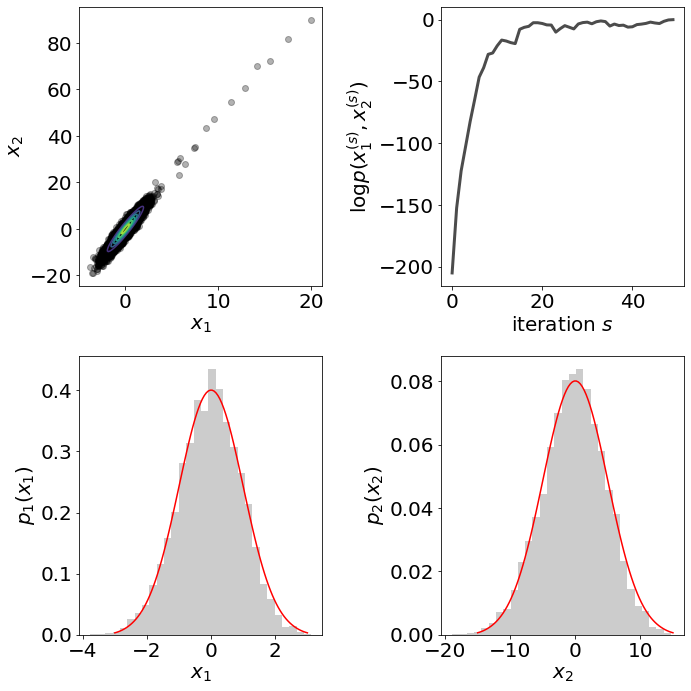

In [17]:
import numpy as np
import matplotlib.pylab as plt

from scipy.special import logsumexp

class Gaussian:
    """Bivariate Gaussian
    """
    def __init__(self, mu = np.zeros(2), sigma1=1., sigma2=3., rho=0.95):

        self.mu = mu
        self.sigma = np.array([sigma1, sigma2])
        self.rho = float(rho)

    @property
    def sigma1(self):
        return self.sigma[0]

    @property
    def sigma2(self):
        return self.sigma[1]
        
    @property
    def Sigma(self):
        """
        Covariance matrix
        """
        Sigma = np.diag([self.sigma1, self.sigma2])
        Sigma = Sigma @ np.array([[1, self.rho], [self.rho, 1]]) @ Sigma
        return Sigma

    @property
    def Lambda(self):
        """
        Precision matrix
        """
        precision = np.diag([1/self.sigma1, 1/self.sigma2]) / np.sqrt(1 - self.rho**2)
        precision = precision @ np.array([[1, -self.rho], [-self.rho, 1]])  @ precision
        return precision

    def log_prob(self, x):
        logp = -.5 * np.sum(x * x.dot(self.Lambda), -1)
        return logp

    def sample_conditional(self, x, index=0):

        ratio = self.rho * self.sigma[index] / self.sigma[1-index]
        
        mu = self.mu[index] + ratio * (x[1-index] - self.mu[1-index])
        sigma = np.sqrt(1-self.rho**2) * self.sigma[index]

        return np.random.standard_normal() * sigma + mu

    def sample_marginal(self, index=0):

        mu = self.mu[index]
        sigma = self.sigma[index]

        return np.random.standard_normal() * sigma + mu

    
def compute_marginal(prob, axis=0, x=None):
    marginal = logsumexp(prob, axis=axis)
    marginal -= logsumexp(marginal)
    if x is not None:
        marginal -= np.log(x[1]-x[0])
    return marginal


pdf = Gaussian(sigma1=1., sigma2=5., rho=0.95)
x = np.linspace(-1., 1., 100) * 3 * pdf.sigma1
y = np.linspace(-1., 1., 100) * 3 * pdf.sigma2

X, Y = np.meshgrid(x, y)
grid = np.transpose([X.flatten(), Y.flatten()])
prob = pdf.log_prob(grid).reshape(len(x), -1)

samples = [(20., 90.)]
while len(samples) < 1e4:
    newstate = list(samples[-1])
    for index in [0, 1]:
        newstate[index] = pdf.sample_conditional(newstate, index)
    samples.append(tuple(newstate))
samples = np.array(samples)

logp = pdf.log_prob(samples)
burnin = int(0.1*len(samples))

kw_hist = dict(bins=30, color='k', density=True, alpha=0.2)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = list(ax.flat)
#
ax[0].scatter(*samples.T, color='k', alpha=0.3)
ax[0].contour(x, y, np.exp(prob))
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
#
ax[1].plot(logp[:50], color='k', lw=3, alpha=0.7)
ax[1].set_xlabel(r'iteration $s$')
ax[1].set_ylabel(r'$\log p(x_1^{(s)}, x_2^{(s)})$')
#
ax[2].hist(samples[burnin:,0], **kw_hist)
ax[2].plot(x, np.exp(compute_marginal(prob, 1, x)), color='r')
ax[2].set_xlabel(r'$x_1$')
ax[2].set_ylabel(r'$p_1(x_1)$')
#
ax[3].hist(samples[burnin:,1], **kw_hist)
ax[3].plot(y, np.exp(compute_marginal(prob, 0, y)), color='r')
ax[3].set_xlabel(r'$x_2$')
ax[3].set_ylabel(r'$p_2(x_2)$')
#
fig.tight_layout()

This collapsed Gibbs sampler uses the marginal distribution to sample $x_1$ and the conditional distribution to sample $x_2$:

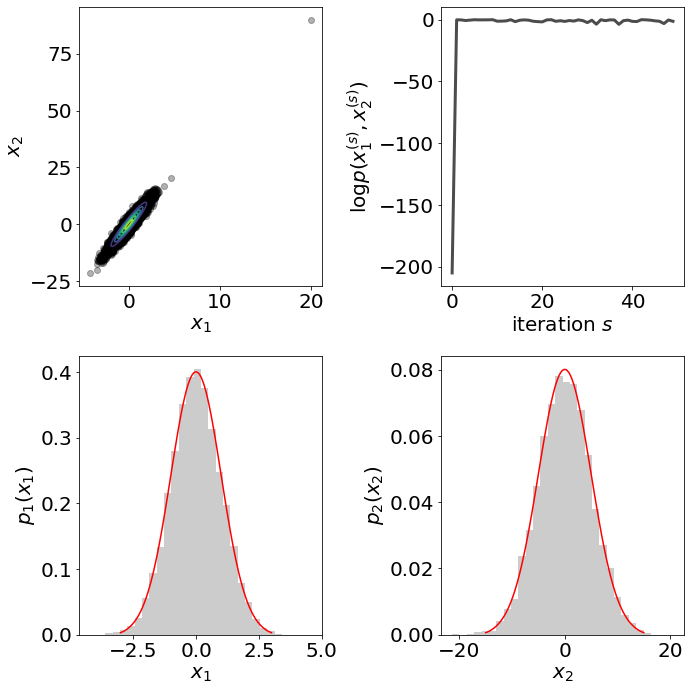

In [18]:
# collapsed Gibbs 1

samples = [(20., 90.)]
while len(samples) < 1e4:
    newstate = list(samples[-1])
    newstate[0] = pdf.sample_marginal(0)
    newstate[1] = pdf.sample_conditional(newstate, 1)
    samples.append(tuple(newstate))
samples = np.array(samples)

logp = pdf.log_prob(samples)
burnin = int(0.1*len(samples))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = list(ax.flat)
#
ax[0].scatter(*samples.T, color='k', alpha=0.3)
ax[0].contour(x, y, np.exp(prob))
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
#
ax[1].plot(logp[:50], color='k', lw=3, alpha=0.7)
ax[1].set_xlabel(r'iteration $s$')
ax[1].set_ylabel(r'$\log p(x_1^{(s)}, x_2^{(s)})$')
#
ax[2].hist(samples[burnin:,0], **kw_hist)
ax[2].plot(x, np.exp(compute_marginal(prob, 1, x)), color='r')
ax[2].set_xlabel(r'$x_1$')
ax[2].set_ylabel(r'$p_1(x_1)$')
#
ax[3].hist(samples[burnin:,1], **kw_hist)
ax[3].plot(y, np.exp(compute_marginal(prob, 0, y)), color='r')
ax[3].set_xlabel(r'$x_2$')
ax[3].set_ylabel(r'$p_2(x_2)$')
#
fig.tight_layout()

This collapsed Gibbs sampler uses the marginal distribution to sample $x_2$ and the conditional distribution to sample $x_1$:

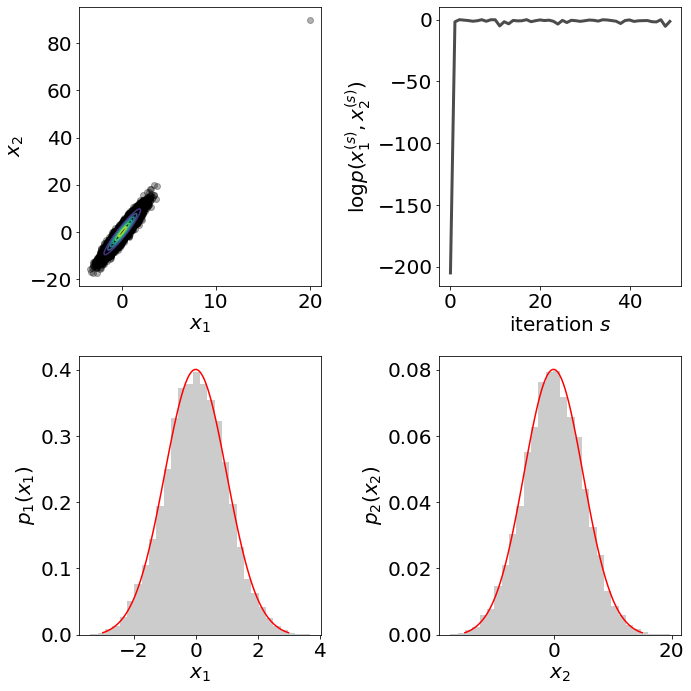

In [19]:
# collapsed Gibbs 2

samples = [(20., 90.)]
while len(samples) < 1e4:
    newstate = list(samples[-1])
    newstate[1] = pdf.sample_marginal(1)
    newstate[0] = pdf.sample_conditional(newstate, 0)
    samples.append(tuple(newstate))
samples = np.array(samples)

logp = pdf.log_prob(samples)
burnin = int(0.1*len(samples))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = list(ax.flat)
#
ax[0].scatter(*samples.T, color='k', alpha=0.3)
ax[0].contour(x, y, np.exp(prob))
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
#
ax[1].plot(logp[:50], color='k', lw=3, alpha=0.7)
ax[1].set_xlabel(r'iteration $s$')
ax[1].set_ylabel(r'$\log p(x_1^{(s)}, x_2^{(s)})$')
#
ax[2].hist(samples[burnin:,0], **kw_hist)
ax[2].plot(x, np.exp(compute_marginal(prob, 1, x)), color='r')
ax[2].set_xlabel(r'$x_1$')
ax[2].set_ylabel(r'$p_1(x_1)$')
#
ax[3].hist(samples[burnin:,1], **kw_hist)
ax[3].plot(y, np.exp(compute_marginal(prob, 0, y)), color='r')
ax[3].set_xlabel(r'$x_2$')
ax[3].set_ylabel(r'$p_2(x_2)$')
#
fig.tight_layout()

# Auxiliary Variables

The idea of sampling methods that use *auxiliary variables* is to *introduce* new variables rather than marginalizing them out. The target distribution is $p(x)$ defined over sample space $\mathcal X$. But it might be beneficial to introduce helper variables $y$ and consider $p(x, y)$ defined over the extended sample space $\mathcal X \times{} \mathcal Y$ where

$$
p(x) = \int_{\mathcal{Y}} p(x, y)\, dy
$$

If we can generate samples $\bigl(x^{(s)}, y^{(s)}\bigr) \sim p(x, y)$, then a valid estimator for expectations of $p(x)$ is

$$
\mathbb{E}_p[f] \approx \frac{1}{S} \sum_{s=1}^S f\bigl(x^{(s)}\bigr)\, .
$$

Why is this helpful? We can use Gibbs sampling to generate samples from $p(x, y)$:

\begin{align}\label{eq:gibbs-auxiliary}
\begin{split}
x^{(s+1)} &\sim p\bigl(x | y^{(s)}\bigr) \\
y^{(s+1)} &\sim p\bigl(y | x^{(s+1)}\bigr) \\
\end{split}
\end{align}

where the marginal distributions might be easier to simulate than $p(x)$.

#### Example: Student-t distribution

The [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) is defined as

$$
p(x | \nu) = \frac{1}{Z(\nu)} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}
$$

with a normalization constant $Z(\nu)$ that depends on the degrees of freedom $\nu > 0$. 

This integral can be written as a [scale-mixture of normals](https://www.jstor.org/stable/2984774?seq=1#metadata_info_tab_contents):

\begin{eqnarray*}
f(x ; \alpha, \beta) &=& \int \underbrace{\sqrt{\frac{s}{2\pi}}\, e^{-\frac{s}{2} x^2 }}_{\text{Gaussian}}\,\,\, \underbrace{\frac{\beta^\alpha}{\Gamma(\alpha)} s^{\alpha -1} e^{-\beta s}}_{\text{Gamma distribution}} ds \\
&=& \frac{\beta^\alpha}{\Gamma(\alpha)\,\sqrt{2\pi}} \int s^{\frac{2\alpha + 1}{2} - 1}\,\, \exp\left\{-s(\beta + x^2/2)\right\} ds \\
&=& \frac{\beta^\alpha}{\Gamma(\alpha)\,\sqrt{2\pi}} \frac{\Gamma(\alpha+1/2)}{\left(\beta + x^2/2\right)^{\frac{2\alpha+1}{2}}} \\
&=& \frac{1}{\sqrt{2\pi\beta}} \frac{\Gamma(\alpha+1/2)}{\Gamma(\alpha)} \left(1 + x^2/2\beta\right)^{-(\frac{2\alpha+1}{2})} \\
\end{eqnarray*}

So $f(x; \alpha, \beta)$ is identical to $p(x|\nu)$ for $\alpha=\nu/2$ and $\beta=\nu/2$.

The joint distribution is

$$
p(x, s) = p(x | s) p(s) = \mathcal{N}(x; 0, s^{-1/2})\, \mathcal{G}(s; \nu/2, \nu/2)
$$

The conditional distributions are $\mathcal{N}(x; 0, s^{-1/2})$ and $\mathcal{G}(s; (\nu+1)/2, (\nu+x^2)/2)$.

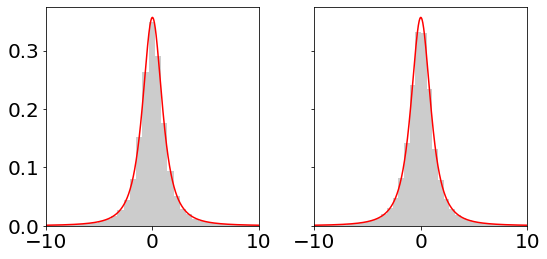

In [20]:
# sample student t with auxiliary variable

nu = 2.
alpha = nu / 2
beta = nu / 2

log_target = lambda x : - 0.5 * (nu+1.) * np.log(1 + x**2/nu)

# standard Gibbs sampler
x = 0.
samples = []
while len(samples) < 1e5:
    s = np.random.gamma(alpha+0.5, 1/(beta + 0.5*x**2))
    x = np.random.standard_normal() / np.sqrt(s)
    samples.append(x)
    
# collapsed Gibbs sampler
s = np.random.gamma(alpha, 1/beta, size=len(samples))
samples2 = np.random.standard_normal(len(s)) / np.sqrt(s)
    
burnin = int(0.1*len(samples))
    
t = np.linspace(-1., 1., 1000) * 10
p = log_target(t)
p -= logsumexp(p) + np.log(t[1]-t[0])
p = np.exp(p)

kw = dict(xlim=(-10., 10.))
kw_hist = dict(bins=1000, density=True, color='k', alpha=0.2)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all', subplot_kw=kw)
ax[0].hist(samples[burnin:], **kw_hist)
ax[1].hist(samples2[burnin:], **kw_hist)
for a in ax:
    a.plot(t, p, color='r')
fig.tight_layout();

# Lecture 7: Hamiltonian Monte Carlo

Michael Habeck - University Hospital Jena - michael.habeck@uni-jena.de

## Outline

* Recap: MCMC + Gibbs Sampling
* More on auxiliary variable methods
* Hamiltonian Monte Carlo

# Recap

* __Metropolis-Hastings algorithm:__ Take (almost) any Markov chain $Q$ (proposal chain) and map it to a new Markov chain $M[Q]$ with a desired proposal distribution $p$:
$$
M[Q](y, x) = Q(y, x) \, \min\left\{1, \frac{Q(x, y)}{Q(y, x)} \frac{p(y)}{p(x)} \right\},\,\,\, y\not= x
$$

* __Metropolis-within-Gibbs:__ Multiple proposal kernels $P_i$ that have the same stationary distribution $p$ can be combined to produce a new kernel $P=\prod_i P_i$ with the same stationary distribution. A special case is to use proposal chains $Q_i$ that only update a group of variables $x_i$ and leave the other variables $x_{\setminus i}$ untouched:
$$
Q_i(y, x) = \delta(y_{\setminus i} - x_{\setminus i})\, q_i(y_i, x_i; x_{\setminus i})
$$
The Metropolis map of $Q_i$ simulates a Markov chain in the subspace $\mathcal X_i$ with proposal kernel $q_i$.

* __Gibbs sampling:__ A special case is $q_i(y_i, x_i; x_{\setminus i}) = p_i(y_i|x_{\setminus i})$ (the proposal is the conditional distribution $p_i$ of the $i$-th group of variables), which results in proposals that are always accepted. 

# Auxiliary variable methods

The idea of auxiliary variable methods is to introduce helper variables $y\in\mathcal Y$ that facilitate sampling. The joint distribution $p(x, y)$ over the extended sample space $\mathcal X \times{} \mathcal Y$ has to be designed such that

$$
p(x) = \int_{\mathcal{Y}} p(x, y)\, dy\, .
$$

Samples $\bigl(x^{(s)}, y^{(s)}\bigr) \sim p(x, y)$ can then be used to estimate expectations with respect to $p(x)$:

$$
\mathbb{E}_p[f] = \int_{\mathcal X} f(x)\, p(x)\, dx = \int_{\mathcal X \times \mathcal Y} f(x)\, p(x, y)\, dx dy \approx \frac{1}{S} \sum_{s=1}^S f\bigl(x^{(s)}\bigr)\, .
$$

Why is this helpful? We can use Gibbs sampling to generate samples from $p(x, y)$:

\begin{align}\label{eq:gibbs-auxiliary2}
\begin{split}
x^{(s+1)} &\sim p\bigl(x | y^{(s)}\bigr) \\
y^{(s+1)} &\sim p\bigl(y | x^{(s+1)}\bigr) \\
\end{split}
\end{align}

where the marginal distributions might be easier to simulate than $p(x)$.

### Example: Swendsen-Wang algorithm

An example of an auxiliary variable method is the [Swendsen-Wang algorithm](https://en.wikipedia.org/wiki/Swendsen%E2%80%93Wang_algorithm) for sampling Ising models. The Ising model (see lecture 1) is defined on a two-dimensional square lattice of length $L$. The sample space is $\mathcal X = \{-1, +1\}^{L \times L}$. The probability is

$$
p(x) \propto \exp\left\{\beta \sum_{i\sim j} x_i x_j \right\}
$$

where $i\sim j$ indicates if two nodes $i$ and $j$ are nearest neighbors on the square lattice (assuming periodic boundary conditions). In the first lecture, we saw that it is challenging to simulate the Ising model for $\beta \simeq 0.44$, because of a phase transition: For $\beta$ larger than the critical value, spin variables become highly correlated which makes the sampling quite challenging.

The sampling strategy used in lecture 1 can be interpreted as "Metropolis-within-Gibbs": The entire 2D lattice is scanned (a loop over all lattice sites is called a *sweep*). At each lattice site, we try to flip the spin: If $x_i$ is the current value of spin $i$, then the flipped value is $x_i'=-x_i$; all other spin variables are unchanged. That is, the proposal kernel $Q_i$ only affects a single site and is symmetric and deterministic. A spin flip is accepted with probability:

$$
\frac{p(x')}{p(x)} = \exp\left\{\beta\sum_{i\sim j} (x_i'x_j' - x_i x_j) \right\} = \exp\left\{-2\beta x_i S_i \right\}
$$

where $S_i = \sum_{j\sim i} x_j$ is the total spin of the nearest neighbors, which can be evaluated very efficiently. 

In [21]:
%load_ext Cython

In [22]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

    
@cython.boundscheck(False)
@cython.wraparound(False)
def ising_energy(np.int64_t[:, :] x):
    cdef int N = x.shape[0]
    cdef int M = x.shape[1]
    cdef int E = 0
    cdef int i, j
    for i in range(N):
        for j in range(M):
            E -= x[i,j] * (x[i,(j+1)%M] + x[(i+1)%N, j])
    return E


@cython.boundscheck(False)
@cython.wraparound(False)
def ising_sweep(np.int64_t[:, :] x, float beta=0.4):
    cdef int N = x.shape[0]
    cdef int M = x.shape[1]
    cdef int start_i, start_j, i, j
    for start_i in range(2):
        for start_j in range(2):
            for i in range(start_i, N, 2):
                for j in range(start_j, M, 2):
                    ising_flip(x, i, j, beta)
    return np.array(x)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef ising_flip(np.int64_t[:, :] x, int i, int j, float beta):
    cdef int N = x.shape[0]
    cdef int M = x.shape[1]
    cdef int S = x[(i-1)%N,j] + x[(i+1)%N,j] + x[i,(j-1)%M] + x[i,(j+1)%M]
    if exp(-2 * beta * x[i, j] * S) * RAND_MAX > rand():
        x[i, j] *= -1

To improve the sampling of spin configuration, we introduce auxiliary variables $b_{ij} \in \{0, 1\}$, also called *bond variables*, for each pair of spins $i$ and $j$ that are neighbors on the square lattice: $i\sim j$. The bond variables indicate if two neighboring spins $x_i$, $x_j$ are aligned (i.e. have the same spin or color):

$$
b_{ij} = \left\{\begin{array}{c c} 1 & \text{if } x_i = x_j \\ 0 & \text{else} \\
\end{array}\right.
$$

The bond variables can be seen as Bernoulli coins that are tossed independently of each other. For spins that are aligned, the probability for forming a bond between sites $i$ and $j$, $b_{ij}=1$, is $p=1-e^{-2\beta}$. So there is a bias for $b_{ij}$ to form that increases with increasing inverse temperature $\beta$. For spins that are not aligned, the associated bond is *not* formed with probability one. The overall probability is

$$
p(x, b) \propto \prod_{i\sim j} [p\delta(x_i, x_j)]^{b_{ij}} (1-p)^{1-b_{ij}}
$$

where $\delta(x_i, x_j)=1$ if $x_i=x_j$ and $\delta(x_i,x_j)=0$ otherwise. For the Ising model with $x_i=\pm 1$, we can write 

$$
\delta(x_i, x_j) = \frac{x_ix_j + 1}{2}\, .
$$

To verify that the marginal distribution over $x$ is correct, let us compute it by summing over $b_{ij}$:

\begin{align*}
\sum_{b} p(x, b) &\propto \sum_{b} \prod_{i\sim j} [p\delta(x_i, x_j)]^{b_{ij}} (1-p)^{1-b_{ij}}\\
&= \prod_{i\sim j} [p\delta(x_i, x_j) + 1 - p] \\
&= \prod_{i\sim j} [1-p]^{1-\delta(x_i, x_j)} \\
&= \prod_{i\sim j} \exp\left\{-2\beta(1-\delta(x_i, x_j))\right\} \\
&= \prod_{i\sim j} \exp\left\{-\beta(1-x_ix_j)\right\} \\
&\propto \prod_{i\sim j} \exp\left\{\beta x_ix_j\right\} \\
\end{align*}

The conditional distribution of a single bond variable $b_{ij}$ is

$$
p(b_{ij} | x) \propto [p\delta(x_i, x_j)]^{b_{ij}} (1-p)^{1-b_{ij}}
$$

These can be updated by simply generating Bernoulli variables for aligned spins, the other bond variables are set to zero. 

The conditional distribution of the spins is sampled by assigning all spin variables that belong to the same [connected component](https://en.wikipedia.org/wiki/Component_(graph_theory)) of the bond network to a single, randomly selected value $\pm 1$. 

In [23]:
# pure Python implementation of Swendsen-Wang
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sparse

class SwendsenWang:
    
    def __init__(self, L):
        self.L = int(L)
        
        # create edges
        iy, ix = np.meshgrid(np.arange(L), np.arange(L))

        i = np.arange(L**2)
        i = np.concatenate([i, i])
        j = [(L*ix + (iy+1)%L).flatten(), (L*((ix+1)%L) + iy).flatten()]
        j = np.concatenate(j)

        self.edges = np.sort([i, j], 0)

    def adjacency_matrix(self, bonds=None):
        i, j = self.edges
        if bonds is not None:
            i, j = i[bonds], j[bonds]               
        return sparse.csr_matrix(
            (np.ones_like(i), (i, j)), shape=(self.L**2, self.L**2))

    def sample_bonds(self, x, beta=1.):
        x = x.reshape(-1,)
        i, j = self.edges
        aligned = (x[i] == x[j])
        prob = aligned * (1-np.exp(-2*beta)) 
        return np.random.random(len(prob)) < prob

    def sample_spins(self, x, beta=0.):
        x = x.copy().flatten()    
        bonds = self.sample_bonds(x, beta)
        adjacency = self.adjacency_matrix(bonds)
    
        n_comp, labels = sparse.csgraph.connected_components(
            adjacency, directed=False, return_labels=True)

        for label in range(n_comp):
            x[labels==label] = np.random.choice([-1, 1])
            
        return x.reshape(self.L, -1)

In [24]:
# For comparison: mean energy per spin in infinite lattice from Onsager theory
# https://en.wikipedia.org/wiki/Square_lattice_Ising_model#Exact_solution

from scipy import integrate

def energy_per_spin(beta):
    """Average energy per lattice site according to Onsager.
    """
    if np.iterable(beta):
        return np.array(list(map(energy_per_spin, beta)))
    
    # scalar beta
    def f(theta):
        k = 1 / np.sinh(2*beta)**2
        return 1 / np.sqrt(1 - 4*k/(1+k)**2 * np.sin(theta)**2)

    I = integrate.quad(f, 0., 0.5*np.pi)[0]
    I *= 2 * (2*np.tanh(2*beta)**2 - 1) / np.pi
    return - (1 + I) / np.tanh(2*beta)

In [25]:
L = 2**7
x = np.random.choice([-1, 1], (L, L))

# inverse temperature close to critical value
beta = 0.5 * np.log(1 + 2**(1/2))
n_iter = 30

# starting from random configuration (beta=0.) using Metropolis
# algorithm to approach distribution at critical beta
x_MH = x.copy()
E_MH = [ising_energy(x_MH)/L**2]
for _ in range(n_iter):
    x_MH = ising_sweep(x_MH)
    E_MH.append(ising_energy(x_MH)/L**2)
E_MH = np.array(E_MH)

# starting from random configuration (beta=0.) using Swendsen-
# Wang to approach distribution at critical beta
sampler = SwendsenWang(L)
x_SW = x.copy()
E_SW = [ising_energy(x_SW)/L**2]
for _ in range(n_iter):
    x_SW = sampler.sample_spins(x_SW, beta)
    E_SW.append(ising_energy(x_SW)/L**2)
E_SW = np.array(E_SW)

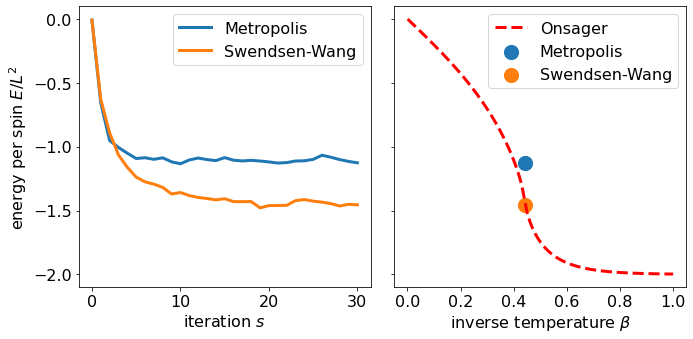

In [26]:
betas = [np.linspace(1e-3, 1., 101), 
         np.linspace(0.2, 0.8, 101)][0]
U = energy_per_spin(betas)

plt.rc('font', size=16)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='all')
ax = list(ax.flat)
ax[0].plot(E_MH, lw=3, label='Metropolis')
ax[0].plot(E_SW, lw=3, label='Swendsen-Wang')
ax[0].set_xlabel(r'iteration $s$')
ax[0].set_ylabel(r'energy per spin $E/L^2$')
ax[0].legend()
ax[1].scatter(beta, E_MH[-1], s=200, label='Metropolis')
ax[1].scatter(beta, E_SW[-1], s=200, label='Swendsen-Wang')
ax[1].plot(betas, U, color='r', ls='--', lw=3, label='Onsager')
ax[1].set_xlabel(r'inverse temperature $\beta$')
ax[1].legend()
fig.tight_layout()

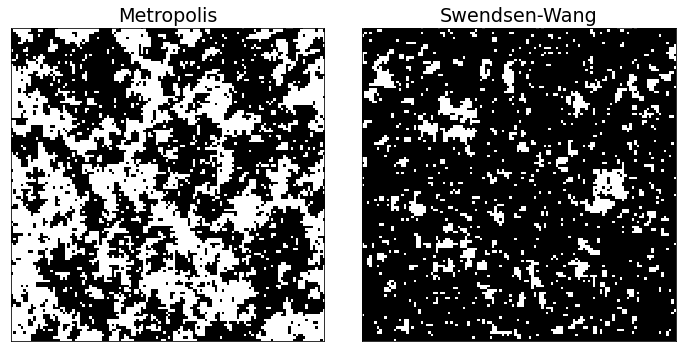

In [27]:
plt.rc('image', interpolation=None, cmap='gray')
kw = dict(xticks=[], yticks=[])
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=kw)
ax[0].set_title('Metropolis')
ax[0].imshow(x_MH.reshape(L, L))
ax[1].set_title('Swendsen-Wang')
ax[1].imshow(x_SW.reshape(L, L))
fig.tight_layout()

# Hamiltonian Monte Carlo

Another auxiliary variable method is [Hamiltonian Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) also known as [*Hybrid Monte Carlo*](https://doi.org/10.1016%2F0370-2693%2887%2991197-X). HMC is among the most widely used methods for sampling probabilistic models over continuous sample spaces. Radford Neal, one of the inventors of HMC, has written a nice introduction that can be found [here](http://www.mcmchandbook.net/HandbookChapter5.pdf).

The idea of HMC is to exploit the following physical analogy: we interpret 

\begin{equation}\label{eq:energy-hmc}
E(x) = - \log p(x)
\end{equation}

as a potential energy function of a physical system with degrees of freedom $x$. Typically, $x\in\mathbb{R}^D$.

We introduce auxiliary variables $v\in\mathbb{R}^D$ that follow a $D$-dimensional standard Gaussian distribution:

$$
p(v) = (2\pi)^{-D/2} \exp\left\{-\|v\|^2 / 2 \right\}
$$

and construct the joint distribution:

\begin{equation}\label{eq:hmc-joint}
p(x, v) = p(x)\, p(v) \propto \exp\left\{- E(x) - \|v\|^2 / 2 \right\}\, .
\end{equation}

It seems that we didn't gain anything by introducing $v$ other than artificially blowing up the problem and writing the joint distribution in some fancy, pseudo-physical way. However, the major insight comes from the fact that if we stretch the physical analogy further, the joint distribution can be viewed as the [canonical ensemble](https://en.wikipedia.org/wiki/Canonical_ensemble) defined over [*phase space*](https://en.wikipedia.org/wiki/Phase_space):

\begin{equation}\label{eq:hmc-hamiltonian}
p(x, v) \propto \exp\left\{- H(x, v)\right\}\,\,\,\text{where}\,\,\,  H(x, v) := \underbrace{\tfrac{1}{2} \|v\|^2}_{\text{kinetic energy}} + \underbrace{E(x)}_{\text{potential energy}}\, .
\end{equation}

Phase space is the joint space of positions $x$ and momenta (velocities) $v$ in our physical analogy, and the total energy is given by the sum of the kinetic and potential energy is called the [*Hamiltonian*](https://en.wikipedia.org/wiki/Hamiltonian_mechanics) of the system. 

## Hamiltonian dynamics

Classical systems with $D$ degrees of freedom evolve in time by the action of the Hamiltonian $H(x, v)$. Trajectories in phase space are given by the time evolution of velocities and positions, $v(t)$ and $x(t)$. The dynamics of the system is described by Hamilton's equations of motion (an elegant generalization of Newton dynamics):

\begin{align}\label{eq:hmc-dynamics}
\begin{split}
\dot{v} &= \frac{d}{dt} v = - \nabla_x H(x, v) \\
\dot{x} &= \frac{d}{dt} x = + \nabla_v H(x, v) \\
\end{split}
\end{align}

where $d/dt$ is the derivative with respect to time $t$ and abbreviated by a dot (as in $\dot{x}$), and $\nabla_x, \nabla_v$ are the gradients with respect to positions $x$ and momenta $v$. 

The hallmark of Hamiltonian dynamics (Eq. \ref{eq:hmc-dynamics}) of an isolated classical system is that it conserves the total energy. This is clear from

$$
\frac{d}{dt} H = (\nabla_x H(x, v))^T\dot{x} + (\nabla_v H(x, v))^T\dot{v} = (\nabla_x H)^T\!(\nabla_v H) - (\nabla_v H)^T\!(\nabla_x H) = 0
$$

where we used the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) to compute the [total derivative](https://en.wikipedia.org/wiki/Total_derivative) of the Hamiltonian with respect to time (note that there is no explicit time dependence of $H$, i.e. $\partial_t H=0$). 

The trick of HMC is to sample the momenta $v$ from the collapsed distribution

$$
v^{(s)} \sim \mathcal N(0, I_D)
$$

and evolve the system to a proposal state starting from the previous positions $x^{(s)}$ and the newly sampled momenta $v^{(s)}$. If the time evolution is based on Hamiltonian dynamics, we know that the Hamiltonian $H(x, v)$ is conserved. So if $H(x^{(s)}, v^{(s)})$ is the total energy of the current state, then the Hamiltonian of the proposal state $\bigl(x(T), v(T)\bigr)$ where $T$ is the integration time will be the same:

$$
H\bigl(x(T), v(T)\bigr) = H\bigl(x^{(s)}, v^{(s)}\bigr)\,\,\,\text{where}\,\,\,  \bigl(x^{(s)}, v^{(s)}\bigr) \xrightarrow[\text{dynamics}]{\text{Hamiltonian}} \bigl(x(T), v(T)\bigr) \,.
$$

The probability for accepting $\bigl(x(T), v(T)\bigr)$ as new state $\bigl(x^{(s+1)}, v^{(s+1)}\bigr)$ is given by the ratio

$$
\frac{p\bigl(x(T),v(T)\bigr)}{p\bigl(x^{(s)}, y^{(s)}\bigr)} = \exp\left\{-\Delta H \right\}\,\,\, \text{with}\,\,\, \Delta H = H\bigl(x(T), v(T) \bigr) -  H\bigl(x^{(s)}, v^{(s)} \bigr)\, .
$$

This ratio doesn't depend on the proposal probabilities, because Hamiltonian dynamics is [symplectic](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian)), i.e. the chance for going from one point in phase space to another point in phase space is the same for the reverse dynamics (volumes in phase space don't change under Hamiltonian dynamics, the dynamics of the system is incompressible). So the proposal chain is symmetric and proposal probabilities cancel out in the acceptance step. 

Since the total energy of the start and proposal state are the same, we have $\Delta H = 0$ and the proposed state will be accepted with probability one.

### Example: Harmonic oscillator

Let us consider a concrete example whose dynamics can be solved exactly: the [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator) which corresponds to a Gaussian model:

$$
H(x, v) = v^2 / 2 + k x^2 / 2
$$

with the following dynamics:

\begin{align}
\begin{split}
\dot{x} &= +\frac{\partial H}{\partial v} = v \\
\dot{v} &= -\frac{\partial H}{\partial x} = -k x\\
\end{split}
\end{align}

In matrix-vector form we have

\begin{equation}\label{eq:oscillator}
\frac{d}{dt} \begin{pmatrix} v\\ x\end{pmatrix} = \begin{pmatrix} 0 & -k \\ 1 & 0 \\ \end{pmatrix} \begin{pmatrix} v\\ x\end{pmatrix} = A \begin{pmatrix} v\\ x\end{pmatrix}\,\,\,\Rightarrow\,\,\, \begin{pmatrix} v(t)\\ x(t)\end{pmatrix} = \exp\{tA\} \begin{pmatrix} v_0\\ x_0\end{pmatrix}
\end{equation}

where $\exp\{tA\}$ is a matrix exponential $\exp\{tA\} = \sum_n \frac{t^n}{n!} A^n$. The matrix powers have a simple structure: 

$$
A^{2n} = (-k)^n I, \,\,\, A^{2n+1} = (-k)^n A
$$

So the solution of the Hamilton equations is (with $\omega = \sqrt{k}$):

\begin{eqnarray*}\label{eq:oscillator2}
\begin{pmatrix} v(t)\\ x(t)\end{pmatrix} &=& I \sum_{n} \frac{(-)^n}{(2n)!} (\omega t)^{2n} \begin{pmatrix} v_0\\ x_0\end{pmatrix} + \omega^{-1}A \sum_{n} \frac{(-)^n}{(2n+1)!} (\omega t)^{2n+1} \begin{pmatrix} v_0\\ x_0\end{pmatrix} \\
&=& \biggl(I \cos(\omega t) + \omega^{-1}A \sin(\omega t)\biggr) \begin{pmatrix} v_0\\ x_0\end{pmatrix} \\
&=& \begin{pmatrix} \cos(\omega t) & -\omega\sin(\omega t)\\ \sin(\omega t)/\omega  & \cos(\omega t) \\ \end{pmatrix} \begin{pmatrix} v_0\\ x_0\end{pmatrix} 
\end{eqnarray*}

The Hamiltonian $H(x, v)$ is indeed conserved (*Exercise*). 

We can now sample a Gaussian model by exploiting the physical analogy to the harmonic oscillator. We pretend that we can only sample the momenta from a standard normal distribution, and then use the dynamics of the harmonic oscillator to generate a proposal state that is accepted with probability one:

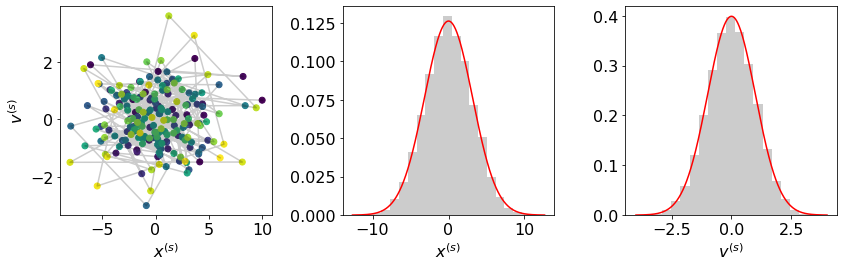

In [28]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('image', cmap='viridis')


class Oscillator:

    def __init__(self, k=1., T=1.):

        self.k = float(k)
        self.T = float(T)
        self.A = np.array([[0, 1], [-self.k, 0]])
        self.w = np.sqrt(k)
        
    def propagate(self, x, v, T=None):

        T = self.T if T is None else float(T)
        
        U = np.array([[np.cos(self.w*T), np.sin(self.w*T)/self.w],
                      [-np.sin(self.w*T)*self.w, np.cos(self.w*T)]])

        return U.dot([x, v])

    def calc_hamiltonian(self, x, v):
        return 0.5 * v**2 + 0.5 * self.k * x**2

    def gradient(self, x):
        return self.k * x
    
k = (10., 0.1)[1]
T = 1000.
x0 = 10.

osci = Oscillator(k, T)
samples = [(x0, np.random.standard_normal())]

while len(samples) < 1e4:
    x, v = osci.propagate(*samples[-1])
    v = np.random.standard_normal()
    samples.append((x, v))

samples = np.array(samples)

sigma = 1 / osci.k**0.5

x = np.linspace(-1, 1., 1000) * 4 * sigma
p_x = np.exp(-0.5 * x**2 / sigma**2 - 0.5 * np.log(2*np.pi*sigma**2))

v = np.linspace(-1, 1., 1000) * 4 
p_v = np.exp(-0.5 * v**2 - 0.5 * np.log(2*np.pi))

burnin = 200

kw_hist = dict(bins=20, color='k', density=True, alpha=0.2)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#
ax[0].plot(*samples[:burnin].T, color='k', alpha=0.2)
ax[0].scatter(*samples[:burnin].T, c=np.linspace(0., 1., len(samples[:burnin])), alpha=1.)
ax[0].set_xlabel(r'$x^{(s)}$')
ax[0].set_ylabel(r'$v^{(s)}$')
#
ax[1].hist(samples[burnin:,0], **kw_hist)
ax[1].plot(x, p_x, color='r')
ax[1].set_xlabel(r'$x^{(s)}$')
#
ax[2].hist(samples[burnin:,1], **kw_hist)
ax[2].plot(v, p_v, color='r')
ax[2].set_xlabel(r'$v^{(s)}$')
#
fig.tight_layout()

# Lecture 8: Hamiltonian Monte Carlo, Practical Issues

Michael Habeck - University Hospital Jena - michael.habeck@uni-jena.de

## Outline

* Hamiltonian Monte Carlo continued
* Practical Issues (convergence, diagnostic checks)

## Leapfrog integrator

It is only rarely possible to solve Hamilton's equations of motion in closed form. In practice, we often have to resort to numerical integration methods to solve this system of ordinary differential equations. 

The crucial feature for making HMC work properly is the conservation of phase space volume. If phase space volume is not conserved, symmetry of the proposal chain is no longer guaranteed, and we would have to take into account the forward and backward probabilities in the acceptance ratios. These probabilities cannot be computed for general systems. Therefore, we have to look out for [symplectic integrators](https://en.wikipedia.org/wiki/Symplectic_integrator) that solve Hamilton's equations of motion numerically but still conserve phase-space volume. 

[Leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration) is a simple symplectic integration scheme that is often used as an integrator in HMC. The leapfrog integrator solves a finite-difference version of Hamilton's equations of motion:

\begin{align}\label{eq:leapfrog}
\begin{split}
v(t+\epsilon/2) &= v(t) - (\epsilon/2) \nabla_x E(x(t)) \\
x(t+\epsilon) &= x(t) + \epsilon v(t+\epsilon/2) \\
v(t+\epsilon) &= v(t+\epsilon/2) - (\epsilon/2) \nabla_x E(x(t+\epsilon))
\end{split}
\end{align}

where $\epsilon$ is the time step. The initial positions and momenta $x(0)$ and $v(0)$ are the previous state $x^{(s)}$ and a sample from the standard Gaussian $v^{(s)} \sim \mathcal N(0, I)$. 

The leapfrog equations can be rearranged to avoid unnecessary gradient evaluations: 

1. From $x(0), v(0)$ compute $v(\epsilon/2)$:

$$
v(\epsilon/2) = v(0) - (\epsilon/2) \nabla_x E(x(0))
$$

2. Loop over $T-1$ integration steps:

\begin{align}
\begin{split}
x(t+\epsilon) &= x(t) + \epsilon v(t+\epsilon/2) \\
v(t+3\epsilon/2) &= v(t+\epsilon/2) - \epsilon \nabla_x E(x(t+\epsilon)) \\
\end{split}
\end{align}

3. Last full-step in $x$ and half-step in $v$:

\begin{align}
\begin{split}
x(T) &= x(T-\epsilon) + \epsilon v(T-\epsilon/2)\\
v(T) &= v(T-\epsilon/2) - (\epsilon/2) \nabla_x E(x(T)) \\
\end{split}
\end{align}

Resulting in $T+1$ gradient evaluations, whereas the original scheme requires two gradient evaluations per time step.

The following demonstration illustrates leapfrog integration for the harmonic oscillator:

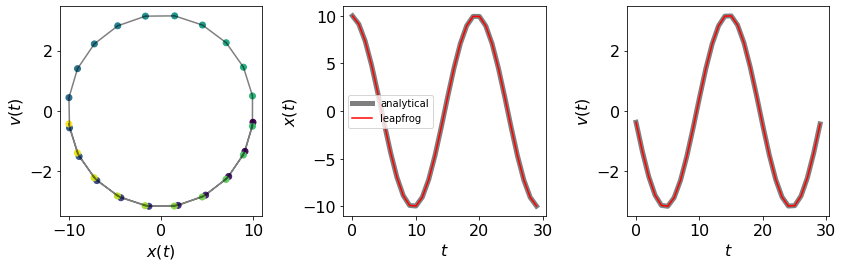

In [29]:
def leapfrog(x0, v0, eps, gradient, n_steps):
    """Leapfrog integration
    """
    x, v = x0, v0
    v -= 0.5 * eps * gradient(x)

    for _ in range(n_steps-1):
        x += eps * v
        v -= eps * gradient(x)
        
    x += eps * v
    v -= 0.5 * eps * gradient(x)

    return x, v

# comparison of leapfrog with analytical solution

x0 = 10.
v0 = np.random.standard_normal()

n_steps = 10
eps = 1e-1
T = eps * n_steps

traj = [(x0, v0)]
traj2 = [(x0, v0)]

while len(traj) < 30:
    x0, v0 = traj[-1]
    x, v = leapfrog(x0, v0, eps, osci.gradient, n_steps)
    traj.append((x, v))
    x0, v0 = traj2[-1]
    traj2.append(osci.propagate(x0, v0, T))

traj = np.array(traj)
traj2 = np.array(traj2)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(*traj.T, color='k', alpha=0.5)
ax[0].scatter(*traj.T, c=np.linspace(0., 1., len(traj)))
ax[0].set_xlabel(r'$x(t)$')
ax[0].set_ylabel(r'$v(t)$')
#
ax[1].plot(traj[:,0], color='k', lw=5, alpha=0.5, label='analytical')
ax[1].plot(traj2[:,0], color='r', label='leapfrog')
ax[1].set_ylim(-11, 11)
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$x(t)$')
ax[1].legend(fontsize=10)
#
ax[2].plot(traj[:,1], color='k', lw=5, alpha=0.5)
ax[2].plot(traj2[:,1], color='r')
#ax[2].set_ylim(-11, 11)
ax[2].set_xlabel(r'$t$')
ax[2].set_ylabel(r'$v(t)$')
#
fig.tight_layout()                             

### Comparison to other integration methods

In his review on HMC, Radford Neal compares the leapfrog integrator with other integration methods such as Euler. The following code reproduces his figure 1

Volume preservation?
         Euler: det(trafo) = 1.090
modified Euler: det(trafo) = 1.000
      Leapfrog: det(trafo) = 1.000


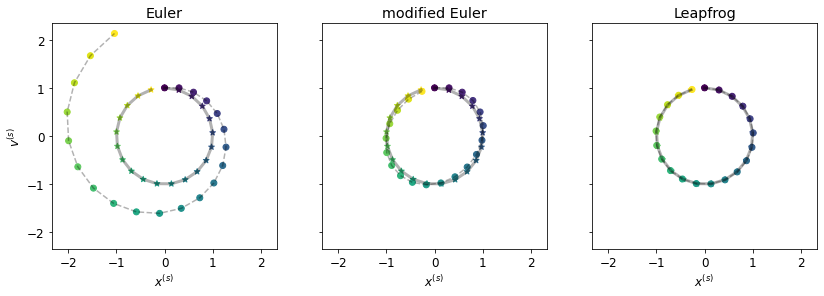

In [30]:
"""
Implementation of examples from Neal's HMC review
"""
import numpy as np
import matplotlib.pylab as plt

def integrate(transformation, n_steps, q0, p0):
    """Integrate Hamilton's equations of motion for the one-dimensional 
    harmonic oscillator using a transformation matrix that implements a
    numerical integration method. 
    """
    z = np.array([q0, p0])
    traj = [z]
    for _ in range(n_steps):
        z = transformation @ z
        traj.append(z)
    return np.array(traj)

def euler(eps, n_steps, q0=0., p0=1.):
    # q(t+eps) = q(t) + eps * p(t)
    # p(t+eps) = p(t) - eps * q(t)
    T = np.array([[1, eps],
                  [-eps, 1]])
    return integrate(T, n_steps, q0, p0), T

def modified_euler(eps, n_steps, q0=0., p0=1.):
    # p(t+eps) = p(t) - eps * q(t)
    T1 = np.array([[1, 0.],
                   [-eps, 1]])
    # q(t+eps) = q(t) + eps * p(t+eps)    
    T2 = np.array([[1, eps],
                   [0, 1]])
    T = T2 @ T1
    
    return integrate(T, n_steps, q0, p0), T
    
def leapfrog(eps, n_steps, q0=0., p0=1.):
    # p(t+eps/2) = p(t) - (eps/2) * q(t)
    T1 = np.array([[1, 0],
                   [-eps/2, 1]])
    # q(t+eps) = q(t) + eps * p(t+eps/2)
    T2 = np.array([[1, eps],
                   [0, 1]])
    # p(t+eps) = p(t+eps/2) - (eps/2) * q(t+eps)
    T3 = T1
    T = T3 @ T2 @ T1
    
    return integrate(T, n_steps, q0, p0), T

###############################################################################
## run all three integrators

eps = (0.3, 1.2, 0.1)[0]
n_steps = int(np.floor(2*np.pi/eps))
n_steps = 20

z1, T1 = euler(eps, n_steps)
z2, T2 = modified_euler(eps, n_steps)
z3, T3 = leapfrog(eps, n_steps)

methods = ('Euler', 'modified Euler', 'Leapfrog')
print('Volume preservation?')
for method, trafo in zip(methods, [T1, T2, T3]):
    print('{0:>14}: det(trafo) = {1:.3f}'.format(method, np.linalg.det(trafo)))

###############################################################################
## plot trajectories

# exact dynamics
x = np.sin(eps * np.arange(n_steps+1))
v = np.cos(eps * np.arange(n_steps+1))
    
limits = np.fabs(z1).max() * 1.1
limits = (-limits, limits)
plt.rc('font', size=12)
plt.rc('image', cmap='viridis')
kw = dict(aspect=1.0, xlim=limits, ylim=limits, xlabel=r'$x^{(s)}$')
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey='all', sharex='all',
                         subplot_kw=kw)
axes[0].set_ylabel(r'$v^{(s)}$')

for ax, method, z in zip(axes, methods, [z1, z2, z3]):
    ax.set_title(method)
    ax.scatter(*z.T, c=np.linspace(0., 1., n_steps+1))
    ax.plot(*z.T, ls='--', color='k', alpha=0.3)
    ax.plot(x, v, color='k', alpha=0.3, lw=3)
    ax.scatter(x, v, c=np.linspace(0., 1., n_steps+1), marker='*')
fig.tight_layout()

## Hamiltonian Monte Carlo
    
Hamiltonian Monte Carlo uses the leapfrog integrator to solve Hamilton's equations of motion. The resulting proposal state is then accepted or rejected according to the Metropolis-Hastings criterion on the augmented $(x, v)$ space (phase space). That is, we accept the new state with probability

$$
\min\left\{1, \exp(-\Delta H)\right\}
$$

which holds since Hamiltonian dynamics and the leapfrog integrator preserve volume (otherwise we would have to take into account the proposal probabilities for the forward and backward dynamics).

### Algorithm: Hamiltonian Monte Carlo

Generate an initial state $x^{(0)} \sim p^{(0)}(x)$ using some initial distribution. For $s=0, 1, 2, \ldots$ cycle over the following iterations

\begin{enumerate}
\item Generate new momenta $v^{(s)} \sim \mathcal N(0, I)$
\item Integrate Hamilton's equations of motion using the leapfrog algorithm resulting in a proposal state $(x', v')$
\item Accept $(x', -v')$ with probability 
$$
\min\left\{1, \exp\bigl(H(x^{(s)}, v^{(s)})-H(x',-v')\bigr) \right\}
$$
as new state $(x^{(s+1)}, -v^{(s+1)})$ 
\end{enumerate}

We have to negate the momenta at the end of the trajectory to make the proposal symmetric. Since Hamiltonian dynamics is reversible, flipping the sign of the momenta guarantees that if we reach $(x', v')$ starting from $(x, v)$ with Hamiltonian dynamics, then we will go back to $(x, v)$ using a dynamics that starts from $(x', -v')$. 

In [31]:
def store(args, storage=None):
    if storage is not None:
        storage.append([np.copy(arg) for arg in args])

        
def leapfrog(x, v, gradient, eps, n_steps, traj=None):
    """Leapfrog integration
    """
    store([x, v], traj)
    for _ in range(n_steps):
        v -= (eps/2) * gradient(x)
        x += eps * v
        v -= (eps/2) * gradient(x)
        store([x, v], traj)
    return x, v


class CoupledOscillator:
    """Coupled oscillator with force constants stored in attribute 'K'"""
    def __init__(self, K):
        self.K = np.array(K)
        self.v, self.U = np.linalg.eigh(self.K)
        self.w = np.sqrt(np.clip(self.v, 0., None))

    def propagate(self, x, v, eps):
        """Move system from (x, v) to new state using Hamiltonian dynamics."""
        x, v = self.U.T @ x, self.U.T @ v
        X = np.cos(self.w*eps) * x + np.sin(self.w*eps) / self.w * v
        V = -np.sin(self.w*eps) * self.w * x + np.cos(self.w*eps) * v
        return self.U @ X, self.U @ V
    
    def energy(self, x):
        return 0.5 * np.sum(x * (x @ self.K), -1)
    
    def gradient(self, x):
        return x @ self.K

    def hamiltonian(self, x, v):
        return self.energy(x) + 0.5 * np.linalg.norm(v, axis=-1)**2
        
def covariance_matrix(sigma1=1., sigma2=1., rho=0.):
    """Build two-dimensional covariance matrix. 
    """
    assert -1. <= rho <= 1.

    Sigma = np.diag([sigma1, sigma2]) \
            @ np.array([[1, rho], [rho, 1]]) \
            @ np.diag([sigma1, sigma2])

    return Sigma

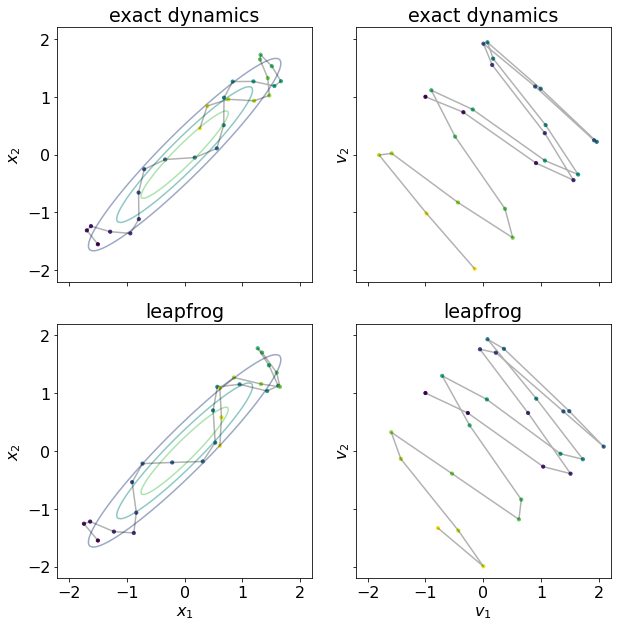

In [32]:
sigma1, sigma2, rho = 1., 1., 0.95
K = np.linalg.inv(covariance_matrix(sigma1, sigma2, rho))
osci = CoupledOscillator(K)

# start position and velocity
x0 = np.array([-1.5, -1.55])
v0 = np.array([-1., 1])
    
n_steps, eps = 250, 0.035
n_steps, eps = 25, 0.25

xvals1 = xvals2 = np.linspace(-1., 1., 101) * 2.5
X1, X2 = np.meshgrid(xvals1, xvals2, indexing='ij')
grid = np.transpose([X1.flatten(), X2.flatten()])
logp = -osci.energy(grid).reshape(len(xvals1), len(xvals2))

# exact dynamics
traj1 = [(x0, v0)]
while len(traj1) < n_steps + 1:
    traj1.append(osci.propagate(*traj1[-1], eps=eps))
x1, v1 = np.array(list(zip(*traj1)))
H1 = osci.hamiltonian(x1, v1)

# leapfrog integration
traj2 = []
leapfrog(x0, v0, osci.gradient, eps, n_steps, traj2)
x2, v2 = np.array(list(zip(*traj2)))
H2 = osci.hamiltonian(x2, v2)

# plot
plt.rc('font', size=16)
limits = (-2.2, 2.2)
kw = dict(xlim=limits, ylim=limits, aspect=1.0)
fig, axes = plt.subplots(2, 2, figsize=(9, 9), sharex='col', 
                         sharey='all', subplot_kw=kw)
axes = list(axes.flat)
for ax, x in zip(axes, [x1, v1, x2, v2]):
    ax.plot(*x.T, color='k', alpha=0.3)
    ax.scatter(*x.T, s=10, c=np.linspace(0., 1., len(x)))
axes[2].set_xlabel(r'$x_1$')
axes[2].set_ylabel(r'$x_2$')
axes[0].set_ylabel(r'$x_2$')
axes[3].set_xlabel(r'$v_1$')
axes[3].set_ylabel(r'$v_2$')
axes[1].set_ylabel(r'$v_2$')
for ax in axes[:2]:
    ax.set_title('exact dynamics')
for ax in axes[-2:]:
    ax.set_title('leapfrog')
axes[0].contour(xvals1, xvals2, np.exp(logp), 3, alpha=0.5)
axes[2].contour(xvals1, xvals2, np.exp(logp), 3, alpha=0.5)
fig.tight_layout()

The exact dynamics conserves the Hamiltonian (as it should), whereas the leapfrog dynamics does not exactly preserve the Hamiltonian:

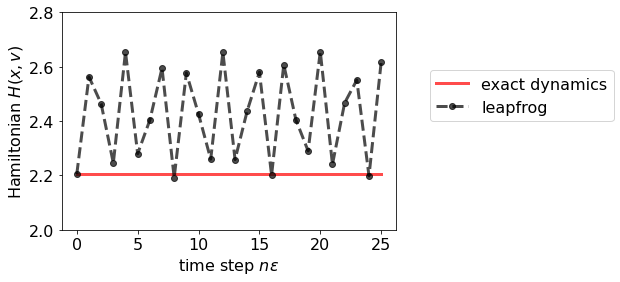

In [33]:
fig, ax = plt.subplots()
ax.plot(H1, lw=3, color='r', ls='-', alpha=0.7, label='exact dynamics')
ax.plot(H2, lw=3, color='k', ls='--', alpha=0.7, marker='o', label='leapfrog')
ax.set_xlabel(r'time step $n\epsilon$')
ax.set_ylabel(r'Hamiltonian $H(x, v)$')
ax.set_ylim(2.0, 2.8)
ax.legend(loc=(1.1, 0.5));

### Comparison with standard Metropolis-Hastings



In [34]:
class Metropolis:

    def __init__(self, model, state, n_samples=1e2, stepsize=1e-1):
        self.model = model
        self.initial_state = np.array(state)
        self.n_samples = int(n_samples)
        self.stepsize = float(stepsize)
        self._reset()
        
    def _reset(self):
        self.counter = 0
        self.state = self.initial_state
        self.n_accepted = 0
        
    def __next__(self):

        if self.counter >= self.n_samples:
            raise StopIteration
        self.counter += 1
        
        # random walk 
        x = self.state.copy()
        X = x + self.stepsize * np.random.standard_normal(x.shape)

        # accept/reject
        diff = self.model.energy(x) - self.model.energy(X)
        accept = np.log(np.random.random()) < diff
        self.n_accepted += int(accept)
        
        if accept: self.state = X

        return self.state

    def __iter__(self):
        self._reset()
        return self

    @property
    def acceptance_rate(self):
        return self.n_accepted / self.n_samples        

    
class HamiltonianMonteCarlo(Metropolis):

    def __init__(self, model, state, n_samples, eps, n_leapfrog):
        super().__init__(model, state, n_samples, eps)
        self.n_leapfrog = int(n_leapfrog)

    def __next__(self):

        if self.counter >= self.n_samples:
            raise StopIteration
        self.counter += 1
        
        # leapfrog integration
        x = self.state.copy()
        v = np.random.standard_normal(x.shape)
        h = self.model.hamiltonian(x, v)
        X, V = leapfrog(
            x, v, self.model.gradient, self.stepsize, self.n_leapfrog)

        # accept/reject
        H = self.model.hamiltonian(X, -V)

        accept = np.log(np.random.random()) < h-H
        self.n_accepted += int(accept)
        
        if accept: self.state = X

        return self.state

acceptance_rate: 89.20% (HMC), 63.04% (Metropolis)


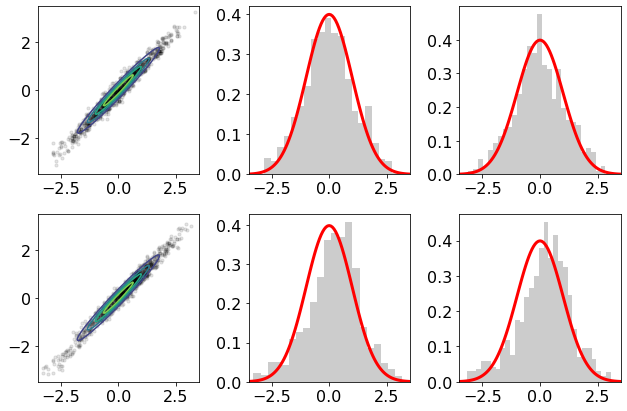

In [35]:
# 2d Gaussian
sigma1 = sigma2 = 1.
rho = 0.98
Sigma = covariance_matrix(sigma1, sigma2, rho)
model = CoupledOscillator(np.linalg.inv(Sigma))

# running HMC and random walk Metropolis
n_samples = 1e3
eps, n_leapfrog = 0.18, 20

initial = np.array([-1.55, -1.5])

hmc = HamiltonianMonteCarlo(model, initial, n_samples, eps, n_leapfrog)
hmc_samples = np.array(list(hmc))

# to be fair, we allow for 'n_leapfrog' more sampling steps in Metropolis 
# sampling
metro = Metropolis(model, initial, n_samples * n_leapfrog, eps)
metro_samples = np.array(list(metro))[::n_leapfrog]

print('acceptance_rate: {0:.2%} (HMC), {1:.2%} (Metropolis)'.format(
    hmc.acceptance_rate, metro.acceptance_rate))

# plotting
burnin = int(0.1*n_samples)
limits = (-3.5, 3.5)
x = np.linspace(*limits, num=101)
grid = np.meshgrid(x, x, indexing='ij')
grid = np.transpose([grid[0].flatten(), grid[1].flatten()])
prob = np.exp(-model.energy(grid)).reshape(len(x), -1)
px = np.exp(-0.5 * x**2 / sigma1**2 - 0.5 * np.log(2*np.pi*sigma1**2))
py = np.exp(-0.5 * x**2 / sigma2**2 - 0.5 * np.log(2*np.pi*sigma2**2))

kw_panel = dict(xlim=limits)
kw_scatter = dict(alpha=0.1, s=10, color='k')
fig, axes = plt.subplots(2, 3, figsize=(9, 6), subplot_kw=kw_panel)

for ax, samples in zip(axes[:,0], [hmc_samples, metro_samples]):
    ax.scatter(*samples.T, **kw_scatter)
    ax.contour(x, x, prob, 5)
    ax.set_ylim(*limits)
for ax, samples in zip(axes[:,1], [hmc_samples, metro_samples]):
    ax.hist(samples[burnin:,0], bins=21, density=True, color='k', alpha=0.2)
    ax.plot(x, px, color='r', lw=3)
for ax, samples in zip(axes[:,2], [hmc_samples, metro_samples]):
    ax.hist(samples[burnin:,1], bins=30, density=True, color='k', alpha=0.2)
    ax.plot(x, py, color='r', lw=3)
fig.tight_layout()

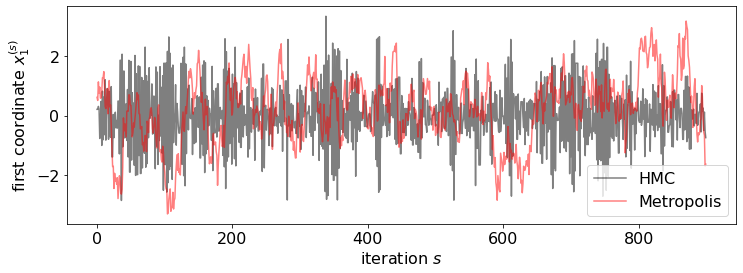

In [36]:
methods = ('HMC', 'Metropolis')
fig, ax = plt.subplots(figsize=(12, 4))
for samples, method in zip([hmc_samples, metro_samples], methods):
    ax.plot(samples[burnin:,0], label=method, alpha=0.5, 
           color={'HMC': 'k', 'Metropolis': 'r'}[method])
ax.set_xlabel(r'iteration $s$')
ax.set_ylabel(r'first coordinate $x_1^{(s)}$')
ax.legend();

Behavior in high-dimensional sample spaces (another example from Radford Neal): 

In [37]:
"""HMC in high dimensions: example from Radford Neal's HMC review
"""
class RandomStepsize:
    """Randomized stepsize mixin. 
    """
    def __init__(self, lower, upper):
        self.lower = float(lower)
        self.upper = float(upper)
        self._value = None
        assert self.lower <= self.upper
        
    @property
    def stepsize(self):
        self._value = np.random.uniform(self.lower, self.upper)
        return self._value
    
    @stepsize.setter
    def stepsize(self, value):
        pass

class MetropolisWithRandomStepsize(Metropolis, RandomStepsize):
    def __init__(self, model, initial, n_samples, lower, upper):
        Metropolis.__init__(self, model, initial, n_samples, lower)
        RandomStepsize.__init__(self, lower, upper)
        
class HMCWithRandomStepsize(HamiltonianMonteCarlo, RandomStepsize):
    def __init__(self, model, initial, n_samples, lower, upper, n_leapfrog):
        HamiltonianMonteCarlo.__init__(
            self, model, initial, n_samples, lower, n_leapfrog
            )
        RandomStepsize.__init__(self, lower, upper)
        
ndim = 100
sigma = np.linspace(0.01, 1., ndim)
model = CoupledOscillator(np.diag(1/sigma**2))
initial = np.zeros(ndim)
n_samples = 2000

# hmc
n_leapfrog = 150
hmc = HMCWithRandomStepsize(
        model, initial, n_samples, 0.0104, 0.0156, n_leapfrog)
samples_hmc = np.array(list(hmc))
print(hmc.acceptance_rate)

# metropolis
metro = MetropolisWithRandomStepsize(
        model, initial, n_samples * n_leapfrog, 0.0176, 0.0264)
samples_metro = np.array(list(metro))[::n_leapfrog]
print(metro.acceptance_rate)

0.8805
0.2514166666666667


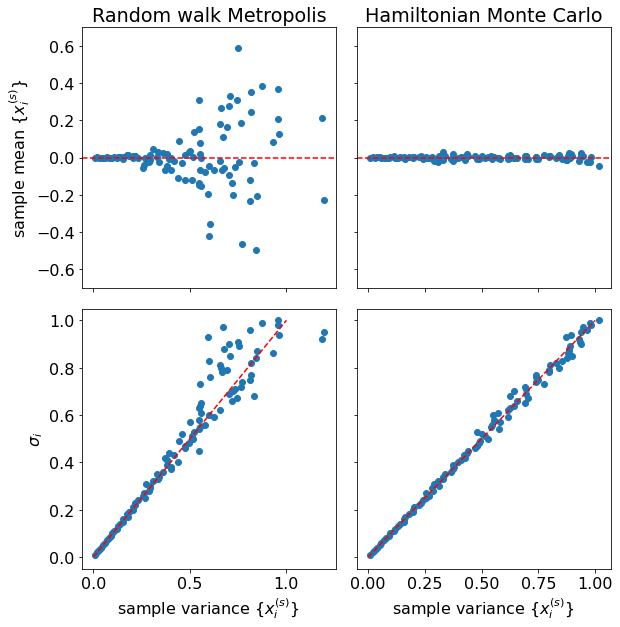

In [38]:
burnin = int(n_samples/10)

# plotting
fig, axes = plt.subplots(2, 2, figsize=(9, 9), sharey='row', sharex='col')
for ax, samples in zip(axes[0,:], [samples_metro, samples_hmc]):
    ax.scatter(samples[burnin:].std(0), samples[burnin:].mean(0))
    ax.axhline(0., ls='--', color='r')
axes[0,0].set_ylim(-0.7, 0.7)
for ax, samples in zip(axes[1,:], [samples_metro, samples_hmc]):
    ax.plot([0., 1.], [0., 1.], ls='--', color='r')
    ax.scatter(samples[burnin:].std(0), sigma)
axes[0,0].set_title('Random walk Metropolis')
axes[0,1].set_title('Hamiltonian Monte Carlo')
axes[0,0].set_ylabel(r'sample mean $\{x_i^{(s)}\}$')
axes[1,0].set_xlabel(r'sample variance $\{x_i^{(s)}\}$')
axes[1,1].set_xlabel(r'sample variance $\{x_i^{(s)}\}$')
axes[1,0].set_ylabel(r'$\sigma_i$')
fig.tight_layout()

A practical issue in applications of HMC is that the algorithm requires the gradient of minus log $p(x)$. For some models it is far from straightforward to implement the gradient. Moreover, the gradient evaluations are on top of the evaluations of $\log p(x)$, which are typical for MCMC approaches based on Metropolis-Hastings. Some remedy is provided by the possibility to use [*automatic differentiation*](https://en.wikipedia.org/wiki/Automatic_differentiation) to compute the gradient without implementing it explicitly. This strategy is used, for example, in the [STAN](https://en.wikipedia.org/wiki/Stan_(software)) software for statistical inference or in probabilistic programming packages such as [tensorflow probability](https://www.tensorflow.org/probability), [PyMC 3](https://docs.pymc.io/), or [pyro](https://pyro.ai/). 

Another issue of practical importance is the question how to choose the algorithmic parameters, i.e. the number of integration steps $T$ and the step size $\epsilon$. Some attempts to choose these parameters automatically has been proposed and implemented in the [NUTS](https://arxiv.org/abs/1111.4246) algorithm.  

A special case of HMC is [Langevin dynamics](https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics) which omits the acceptance/rejection step altogether and has gained some popularity in Bayesian deep learning when combined with stochastic gradient methods. 

# Practical Issues

![Challenges in MCMC](images/Murray_Thesis_Fig2-1.png "Challenges")

Figure from [Iain Murray: Advances in Markov chain Monte Carlo methods](http://homepages.inf.ed.ac.uk/imurray2/pub/07thesis/murray_thesis_2007.pdf)

## Challenges

* __Local exploration__: MCMC samplers typically employ a proposal kernel that changes the current state only locally. The magnitude of changes in the variables is controlled by the *step size* or a similar algorithmic parameter. The step size is limited by the need to maintain a reasonable acceptance rate. The time it takes for a diffusive random walk to explore a distance scales with
$$
(\text{distance} / \text{step size})^2  
$$

* __Convergence__: Typically, the chain starts from a highly improbable state, far away from any mode (local peak in the probability density function). To find a nearby mode, takes some time, again scaling unfavorably with dimension. But even if a mode has been found, it is not guaranteed that the Markov chain will find other modes in a reasonable amount of simulation time. These other modes could be more important in the sense that they carry more probability mass; so missing out on these modes can result in highly biased approximations. 

* __Mixing__: To find all relevant modes, is one of the greatest challenges when sampling high-dimensional probabilistic models with multiple peaks (which is the rule rather than the exception). There are many reasons for having to deal with multi-modal distributions. A common reason are symmetries such as invariance under permutation of labels resulting in the [label-switching problem](https://link.springer.com/chapter/10.1007/978-3-662-01131-7_26) in Gaussian mixture modeling. None of the methods that we discussed so far are particularly suited to explore multi-modal probability distributions. A common approach is to use *tempering* to flatten the probability such that the Markov chain can explore sample space more freely, and simulate a chain of tempered distributions, either sequentially (e.g. in [*Annealed importance sampling* (AIS)](https://link.springer.com/article/10.1023/A:1008923215028)) or in parallel (e.g. in [*Parallel tempering*](https://en.wikipedia.org/wiki/Parallel_tempering)). Unfortunately, there is not enough time to discuss these important methods. 

* __Balancing density and volume__: Another important issue is to not only find all relevant modes, but also visit them in due proportion. A probability peak might be very pronounced, but only carry a small amount of probability mass. If the Markov chain is stuck in this mode, samples coming from that mode will be overrepresented. 

Let's illustrate some of these problems for a discrete toy system.

acceptance rate: 78.0%
22.6% of all samples are in left mode


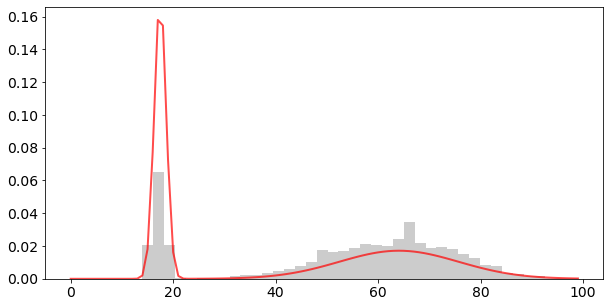

In [39]:
"""
Discretized bimodal target used to study convergence. 
"""
import numpy as np
import matplotlib.pylab as plt

from scipy.special import logsumexp

SEED = [
        # produces bimodal distribution biased towards first mode
        41,
        # produces bimodal distribution biased towards second mode
        1234,
        # produces unimodal sample distribution
        43,   
        ][1]

class BimodalMixture:

    def __init__(self,
                 centers=np.array([0., 1.]),
                 widths=np.array([1., 1.]),
                 weight=0.5):
        self.centers = np.array(centers)
        self.widths = np.array(widths)
        self.weight = float(weight)

    def log_prob(self, x):
        dist = np.subtract.outer(x, self.centers)
        logp = -0.5 * dist**2 / self.widths**2 \
          - 0.5 * np.log(2*np.pi*self.widths**2) \
          + np.log(self.weight) + np.log(1-self.weight)
        return logsumexp(logp, axis=1)

def make_proposal(n_neighbors, n_states):
    Q = np.sum([np.eye(n_states, k=k) for k 
                in range(-n_neighbors, n_neighbors+1)], 0)
    return Q / Q.sum(1)

# setting bimodal toy system
centers = np.array([-1., 1.]) * 4
widths = np.array([0.2, 2.])
weight = 0.5

prob = BimodalMixture(centers, widths, weight)

n = 100            # number of states
X = np.arange(n)   # sample space
p = np.exp(prob.log_prob(np.linspace(-7., 10., n)))
p /= p.sum()       # discretized probability density

# use local proposal chain
stepsize = 5
n_samples = 1e4

# random walk with uniform proposal and reflective boundary
Q = make_proposal(stepsize, n) 

# run Metropolis-Hastings
np.random.seed(SEED) 

n_accepted = 0
x = X[-1]
samples = [x]
while len(samples) < n_samples:
    y = np.random.choice(X, p=Q[:,x])
    r = Q[x,y] * p[y] / (Q[y, x] * p[x])
    if r > np.random.random():
        x = y
        n_accepted += 1
    samples.append(x)
samples = np.array(samples)
logp = np.log(p[samples])

print('acceptance rate: {0:.1%}'.format(n_accepted/n_samples))
print('{0:.1%} of all samples are in left mode'.format(
    np.mean(samples<25)))

# plot results
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, p, color='r', lw=2, alpha=0.7)
ax.hist(samples, bins=40, density=True, color='k', alpha=0.2);


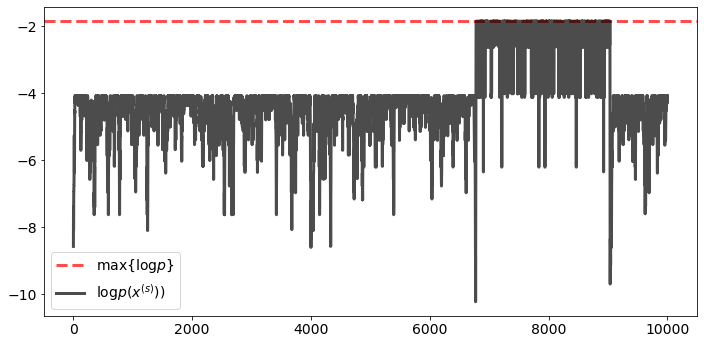

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axhline(np.log(p).max(), color='r', lw=3, ls='--', alpha=0.7,
              label=r'$\max\{\log{p}\}$')
ax.plot(logp, color='k', lw=3, alpha=0.7, label=r'$\log p(x^{(s)}))$')
ax.legend()
fig.tight_layout()

## Convergence

### Convergence rates for Markov chains

The speed of convergence of a Markov chain $P$ with stationary distribution $\pi$ depends on how quickly contributions to the distance

\begin{equation}\label{eq:distance}
\left|p^{(S)} - \pi\right|
\end{equation}

die out as $S\to\infty$. Distance (\ref{eq:distance}) is dominated by the second largest eigenvalue $\lambda_2$ of $P$. Since the Markov chain is assumed to be irreducible and aperiodic, we have strictly $|\lambda_2| < 1$. If $u_2, u_3, \ldots$ are the eigenvectors of $P$ with eigenvalues $1 > |\lambda_2| \ge |\lambda_3| >\ldots$, then we can write the initial distribution as
$$
p^{(0)} = \pi + a_2 u_2 + a_3 u_3 + \ldots
$$
After $S$ transitions, the initial $p^{(0)}$ will be propagated to 
$$
p^{(S)} = \pi + a_2 \lambda_2^S u_2 + a_3 \lambda_3^S u_3 + \ldots
$$
and therefore
$$
\left|p^{(S)} - \pi\right| \sim |\lambda_2|^S
$$

The convergence rate depends on the step size, which calls for ways to *tune* algorithmic parameters of MCMC methods:

In [41]:
def metropolis_map(Q, p):
    """
    Construct Metropolis kernel from proposal kernel and target distribution
    """
    # M = np.clip(Q, 0., (Q * p).T / p)
    M = np.min([Q, (Q * p).T / p], axis=0)
    i = np.arange(len(M))
    M[i,i] = 0.
    M[i,i] = 1 - M.sum(0)

    return M

def second_eigval(M):
    return np.sort(np.abs(np.linalg.eigvals(M)))[::-1][1]    

def propagate(M, p0, n):
    P = [p0.copy()]
    for _ in range(n):
        P.append(M @ P[-1])
    return np.array(P)

In [42]:
stepsizes = (5, 10, 15, 20)
distances = []
rates = []

p0 = np.eye(n)[-1]
for stepsize in stepsizes:
    Q = make_proposal(stepsize, n)
    M = metropolis_map(Q, p)
    P = propagate(M, p0, 10000)
    d = np.fabs(P - p).sum(1)
    distances.append(d)
    rates.append(-np.log(second_eigval(M)))

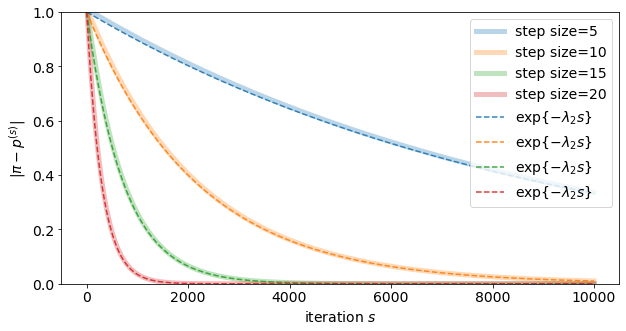

In [43]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(10,5))
for i in range(len(stepsizes)):
    ax.plot(distances[i], alpha=0.3, lw=5, 
            label='step size={0}'.format(stepsizes[i]))
t = np.arange(10000)
for i in range(len(stepsizes)):
    ax.plot(np.exp(-rates[i]*t), ls='--', alpha=0.9, 
            color=colors[i], label=r'$\exp\{-\lambda_2 s\}$')
ax.set_xlabel(r'iteration $s$')
ax.set_ylabel(r'$|\pi - p^{(s)}|$')
ax.legend()
ax.set_ylim(0., 1.);
    

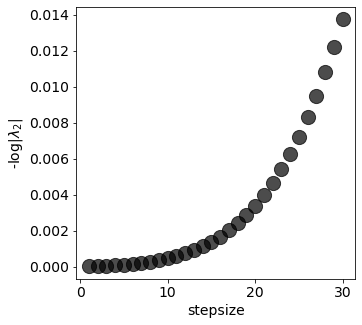

In [44]:
stepsizes = range(1, 31)
rates = []

for stepsize in stepsizes:
    Q = make_proposal(stepsize, n)
    M = metropolis_map(Q, p)
    rates.append(-np.log(second_eigval(M)))
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(stepsizes, rates, s=200, color='k', alpha=0.7)
ax.set_ylabel(r'-$\log|\lambda_2|$')
ax.set_xlabel('stepsize');

### Burn-in bias

The MCMC chain does not start from the stationary distribution, so 
$$
\mathbb E_{p^{(s)}}[f] \not= \mathbb E_p[f]\, , 
$$
and the difference can be substantial for small $s$, thereby inducing significant bias to the Monte Carlo estimator:

\begin{equation}
\frac{1}{S} \sum_{s=1}^S f\bigl(x^{(s)}\bigr).
\end{equation}

It is difficult to assess the reliability of MCMC approximations, because of the dependence of the samples $x^{(s)}$. The dependence usually adds variance to the estimator, when compared against simple Monte Carlo averages.

To minimize biases stemming from a poor choice of the initial distribution $p^{(0)}$, it is common practice to discard the first samples $x^{(0)}, \ldots, x^{(B)}$ called *burn-in*. It is assumed that $x^{(B+1)}$ will approximately follow the target distribution $p$. The Monte Carlo approximation then becomes:
\begin{equation}\label{eq:burnin}
\frac{1}{S-B} \sum_{s=B+1}^S f\bigl(x^{(s)}\bigr)\, .
\end{equation}
Several statistics can be used to detect bias in MCMC simulations. However, they usually rely on rather strong assumptions, such as the asymptotic normality, or at least uni-modality of the target.

### Auto-correlation diagnostic

The asymptotic variance of the MCMC estimator can be shown to converge against
\begin{equation}\label{eq:variance}
\text{var}\left[\frac{1}{S}\sum_s f\bigl(x^{(s)}\bigr) \right] \xrightarrow[S\to\infty]{} \frac{1}{S} \text{var}_p[f] (1 + 2 \sum_{s\ge 1} \rho_s)  
\end{equation}
where $\rho_s$ are the *correlations* between the initial samples and the $s$-th samples
\begin{equation}\label{eq:correlation}
\rho_s = \text{corr}[f(x^{(0)}), f(x^{(s)})] \, .
\end{equation}
For uncorrelated samples $\rho_s=0$ and we are back to the standard variance of Monte Carlo estimators: $\text{var}[f]/S$. However, due to correlations the variance can be increased significantly (in principle, the variance can approach infinity for perfectly correlated samples). 

Another way to look at this is that correlations decrease the *effective sample size* (ESS), which becomes
\begin{equation}\label{eq:ess}
S_{\text{eff}} = \frac{S}{1 + 2 \sum_{s\ge 1} \rho_s} = \frac{S}{\text{IACT}}
\end{equation}
where $\text{IACT} = 1 + 2 \sum_{s\ge 1} \rho_s$ is the *integrated auto-correlation time*. 

In [45]:
# autocorrelation analysis of bimodal target

from csb.statistics import autocorrelation

def run_metropolis(Q, p, X, n_samples=1e4):
    samples = [X[-1]]
    x = samples[0]
    n_acc = 0
    while len(samples) < n_samples:
        y = np.random.choice(X, p=Q[:,x])
        r = Q[x,y] * p[y] / (Q[y, x] * p[x])
        if r > np.random.random():
            x = y
            n_acc += 1
        samples.append(x)
    return np.array(samples), n_acc

np.random.seed(41) 
stepsizes = (5, 10, 15, 20)
ac = []
for stepsize in stepsizes:
    Q = make_proposal(stepsize, len(p))
    S, n_acc = run_metropolis(Q, p, X, 2e4)
    ac.append(autocorrelation(S*1., 10000))
    print('stepsize={0}: acceptance-rate={1:.1%}'.format(
        stepsize, n_acc/len(S)))

stepsize=5: acceptance-rate=57.4%
stepsize=10: acceptance-rate=59.1%
stepsize=15: acceptance-rate=47.0%
stepsize=20: acceptance-rate=36.6%


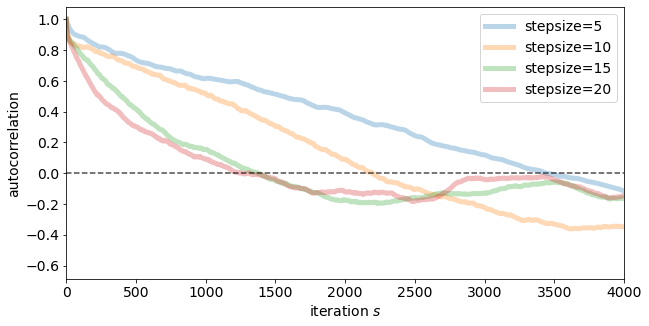

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
for i in range(len(stepsizes)):
    ax.plot(ac[i], alpha=0.3, lw=5, 
            label='stepsize={0}'.format(stepsizes[i]))
ax.axhline(0, ls='--', color='k', alpha=0.7)
ax.set_xlim(0, 4000)
ax.set_xlabel(r'iteration $s$')
ax.set_ylabel(r'autocorrelation')
ax.legend();

### Practical summary (from Vihola's lecture notes)

When using MCMC, always do the following checks:

1. Plot MCMC traces of the variables and key functions of the variables. They should look stationary after burn-in.

2. Make multiple MCMC runs from different initial states and check that the marginal distributions (or the estimators) look similar. This test reveals if your chain is "almost reducible".

3. Plot sample autocorrelations of the variables and functions.

4. Calculate the effective sample size and check that it is reasonably large. 